## Imports

In [121]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import math

## Set up data directories

In [122]:
# Colab env
# from google.colab import drive
# drive.mount('/content/drive')
# input_dir  = Path("/content/drive/MyDrive/Side hustles/DS+X/Data/Raw")
# output_dir = Path("/content/drive/MyDrive/Side hustles/DS+X/Data/Transformed")
# output_dir.mkdir(parents=True, exist_ok=True)

# Local env
input_dir  = Path("2023_data/Bluebikes")
weather_dir = Path("2023_data/Weather")
output_dir = Path("2023_data/Transformed")
output_dir.mkdir(parents=True, exist_ok=True)

## Data extraction functions

In [123]:
def load_raw_data(csv_path):
    df = pd.read_csv(csv_path,
                    dtype={"started_at": "string", "ended_at": "string"},
                    keep_default_na=True,)
    return df

def parse_bike_time(series: pd.Series, freq: str = "h") -> pd.Series:
    s = series.astype(str).str.strip().str.replace("\u200b", "", regex=False)
    dt = pd.to_datetime(s, errors="coerce")
    # fix single-digit hour " 1:" -> " 01:" if needed
    m = dt.isna()
    if m.any():
        s2 = s[m].str.replace(r" (\d):", lambda x: f" 0{x.group(1)}:", regex=True)
        dt.loc[m] = pd.to_datetime(s2, format="%Y-%m-%d %H:%M:%S", errors="coerce")
    return dt.dt.floor(freq)

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    # ---------- Drop rows with missing column data ----------
    df = df.dropna()
    
    # ---------- Standardize column names ----------
    df = df.rename(columns={
        "starttime": "start_time",
        "stoptime": "stop_time",
        "start station id": "start_station_id",
        "start station name": "start_station_name",
        "start station latitude": "start_station_latitude",
        "start station longitude": "start_station_longitude",
        "end station id": "end_station_id",
        "end station name": "end_station_name",
        "end station latitude": "end_station_latitude",
        "end station longitude": "end_station_longitude",
    })
    
    df = df.rename(columns={
        "started_at": "start_time",
        "ended_at": "stop_time",
        "start_station_id": "start_station_id",
        "start_station_name": "start_station_name",
        "start_lat": "start_station_latitude",
        "start_lng": "start_station_longitude",
        "end_station_id": "end_station_id",
        "end_station_name": "end_station_name",
        "end_lat": "end_station_latitude",
        "end_lng": "end_station_longitude",
    })
    
    print("Columns after renaming:", df.columns.tolist())
    
    # ---------- Normalize timestamps to the hour ----------
    df["start_time"] = parse_bike_time(df["start_time"], freq="h")
    df["stop_time"]  = parse_bike_time(df["stop_time"],  freq="h")
    
    # ---------- Filter out trips longer than 24 hours ----------
    df["trip_duration"] = (df["stop_time"] - df["start_time"]).dt.total_seconds() / 3600  # duration in hours
    df = df[df["trip_duration"] <= 24].copy()
    df = df.drop(columns=["trip_duration"])

    # ---------- Organize location data ----------
    start_meta = df[["start_station_id", "start_station_name", "start_station_latitude", "start_station_longitude"]]
    end_meta = df[["end_station_id", "end_station_name", "end_station_latitude", "end_station_longitude"]]
    
    # Rename to common column names for concatenation
    start_meta = start_meta.rename(columns={
        "start_station_id": "station_id",
        "start_station_name": "station_name",
        "start_station_latitude": "latitude",
        "start_station_longitude": "longitude",
    })
    end_meta = end_meta.rename(columns={
        "end_station_id": "station_id",
        "end_station_name": "station_name",
        "end_station_latitude": "latitude",
        "end_station_longitude": "longitude",
    })

    stations = pd.concat([start_meta, end_meta], ignore_index=True)
    stations = stations[stations["station_id"].str.strip() != ""]
    stations = stations.dropna(subset=["station_id"]).drop_duplicates("station_id")

    # ---------- Count OUTS (undocks) by hour & start station ----------
    outs = (
        df.dropna(subset=["start_station_id"])
          .groupby(["start_time", "start_station_id"], as_index=False)
          .size()
          .rename(columns={"start_time": "timestart", "start_station_id": "station_id", "size": "out"})
    )

    # ---------- Count INS (docks) by hour & end station ----------
    ins = (
        df.dropna(subset=["end_station_id"])
          .groupby(["stop_time", "end_station_id"], as_index=False)
          .size()
          .rename(columns={"stop_time": "timestart", "end_station_id": "station_id", "size": "in"})
    )

    # ---------- Combine (outer join so hours with only in OR only out are kept) ----------
    hourly = (
        pd.merge(outs, ins, on=["timestart", "station_id"], how="outer")
          .fillna({"in": 0, "out": 0})
    )

    # ---------- (Optional) Complete grid: every station × every hour ----------
    start_hour = min(df["start_time"].min(), df["stop_time"].min())
    end_hour = max(df["start_time"].max(), df["stop_time"].max())
    all_hours = pd.date_range(start=start_hour, end=end_hour, freq="h")

    all_station_ids = (
        stations["station_id"]
        .dropna()
        .unique()
    )

    full_idx = pd.MultiIndex.from_product(
        [all_hours, all_station_ids],
        names=["timestart", "station_id"]
    )

    hourly = (
        hourly.set_index(["timestart", "station_id"])
              .reindex(full_idx, fill_value=0)
              .reset_index()
    )

    hourly["in"]  = hourly["in"].astype("int64")
    hourly["out"] = hourly["out"].astype("int64")

    # ---------- Attach metadata & compute timeend ----------
    hourly = (
        hourly.merge(stations, on="station_id", how="left")
              .assign(timeend=lambda x: x["timestart"] + pd.Timedelta(hours=1))
    )

    # ---------- Add time-based features from the interval ----------
    month_num = hourly["timestart"].dt.month.astype("int8")
    day_of_week = hourly["timestart"].dt.dayofweek.astype("int8") + 1  # 1=Monday, 7=Sunday
    start_hour = hourly["timestart"].dt.hour.astype("int8")
    end_hour = hourly["timeend"].dt.hour.astype("int8")
    
    # ---------- Add night time indicator (10pm-5am is hours 22, 23, 0, 1, 2, 3, 4) ----------
    is_night = ((start_hour >= 22) | (start_hour <= 4)).astype("int8")
    
    hourly = hourly.assign(
        month=month_num,
        day_of_week=day_of_week,
        start_hour=start_hour,
        end_hour=end_hour,
        is_night=is_night
    )

    # ---------- Add lag features for up to 3 hours ----------
    hourly = hourly.sort_values(["station_id", "timestart"]).reset_index(drop=True)
    
    # 1-hour lag
    hourly["last_hour_in"] = hourly.groupby("station_id")["in"].shift(1)
    hourly["last_hour_out"] = hourly.groupby("station_id")["out"].shift(1)
    
    # 2-hour lag
    hourly["last_two_hour_in"] = hourly.groupby("station_id")["in"].shift(2)
    hourly["last_two_hour_out"] = hourly.groupby("station_id")["out"].shift(2)
    
    # 3-hour lag
    hourly["last_three_hour_in"] = hourly.groupby("station_id")["in"].shift(3)
    hourly["last_three_hour_out"] = hourly.groupby("station_id")["out"].shift(3)
    
    # Fill NaN values with 0
    hourly["last_hour_in"] = hourly["last_hour_in"].fillna(0).astype("int64")
    hourly["last_hour_out"] = hourly["last_hour_out"].fillna(0).astype("int64")
    hourly["last_two_hour_in"] = hourly["last_two_hour_in"].fillna(0).astype("int64")
    hourly["last_two_hour_out"] = hourly["last_two_hour_out"].fillna(0).astype("int64")
    hourly["last_three_hour_in"] = hourly["last_three_hour_in"].fillna(0).astype("int64")
    hourly["last_three_hour_out"] = hourly["last_three_hour_out"].fillna(0).astype("int64")

    # ---------- Final column order ----------
    hourly = (
        hourly.loc[:, [
            "timestart", "timeend",
            "station_name",
            "month", "day_of_week", "start_hour", "end_hour", "is_night",
            "station_id", "latitude", "longitude",
            "in", "out",
            "last_hour_in", "last_hour_out",
            "last_two_hour_in", "last_two_hour_out",
            "last_three_hour_in", "last_three_hour_out"
        ]]
        .sort_values(["timestart", "timeend", "station_name"])
        .reset_index(drop=True)
    )

    return hourly

## Data extraction

In [124]:
files = [
    # "202301-bluebikes-tripdata",
    # "202302-bluebikes-tripdata",
    # "202303-bluebikes-tripdata",
    "202304-bluebikes-tripdata",
    "202305-bluebikes-tripdata",
    "202306-bluebikes-tripdata",
    "202307-bluebikes-tripdata",
    "202308-bluebikes-tripdata",
    "202309-bluebikes-tripdata",
    "202310-bluebikes-tripdata",
    "202311-bluebikes-tripdata",
    "202312-bluebikes-tripdata",
]

paths = [input_dir / f"{file}.csv" for file in files]

# ---------- Process each file separately ----------
all_transformed_data = []
for file, path in zip(files, paths):
    # Load
    df_raw = load_raw_data(path)

    # Transform
    df_transformed = transform_data(df_raw)
    
    # Filter out rows with more than 50 in any of the traffic columns
    df_transformed = df_transformed[
        (df_transformed['in'] <= 50) & 
        (df_transformed['out'] <= 50) & 
        (df_transformed['last_hour_in'] <= 50) & 
        (df_transformed['last_hour_out'] <= 50) &
        (df_transformed['last_two_hour_in'] <= 50) & 
        (df_transformed['last_two_hour_out'] <= 50) &
        (df_transformed['last_three_hour_in'] <= 50) & 
        (df_transformed['last_three_hour_out'] <= 50)
    ]
    
    print(f"Processed {file}: {len(df_transformed)} rows")
    all_transformed_data.append(df_transformed)

    # Save one output per input file
    out_path = output_dir / f"{file}_parsed.csv"
    df_transformed.to_csv(out_path)

# Concatenate all transformed data
df_transformed = pd.concat(all_transformed_data, ignore_index=True)
print(f"\nTotal combined rows: {len(df_transformed)}")
print(df_transformed.columns)

Columns after renaming: ['ride_id', 'rideable_type', 'start_time', 'stop_time', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'member_casual']
Processed 202304-bluebikes-tripdata: 327433 rows
Processed 202304-bluebikes-tripdata: 327433 rows
Columns after renaming: ['ride_id', 'rideable_type', 'start_time', 'stop_time', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'member_casual']
Columns after renaming: ['ride_id', 'rideable_type', 'start_time', 'stop_time', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'member_casual']
Processed 202305-bluebikes-tripdata: 345530 rows
Processed 202305

## Data analysis

Global distribution of in and out counts

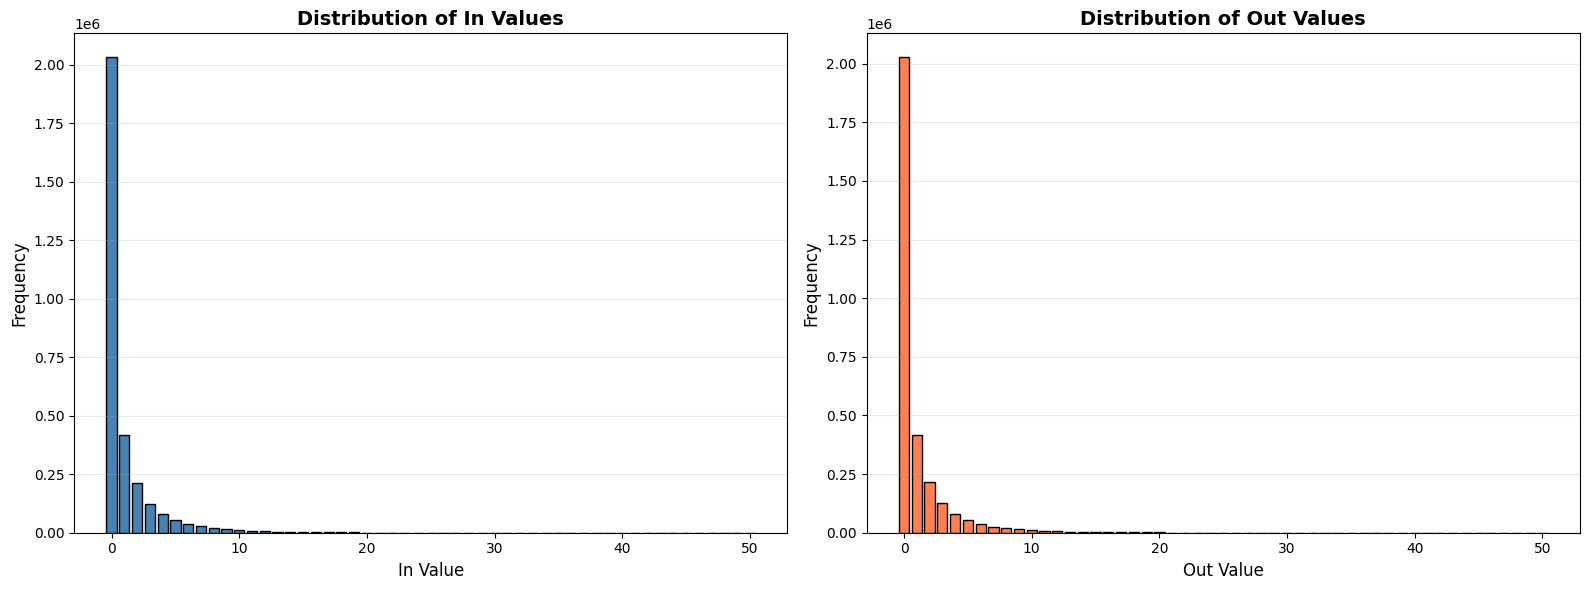

In [125]:
# Calculate distribution of 'in' and 'out' values
in_distribution = df_transformed['in'].value_counts().sort_index()
out_distribution = df_transformed['out'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 'in' values
ax1.bar(in_distribution.index, in_distribution.values, color='steelblue', edgecolor='black')
ax1.set_xlabel('In Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of In Values', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 'out' values
ax2.bar(out_distribution.index, out_distribution.values, color='coral', edgecolor='black')
ax2.set_xlabel('Out Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Out Values', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Top 20 most used stations

In [126]:
# Calculate total activity (ins + outs) for each station
station_activity = df_transformed.groupby('station_name').agg({
    'in': 'sum',
    'out': 'sum'
}).reset_index()

# Calculate total activity
station_activity['total_activity'] = station_activity['in'] + station_activity['out']

# Get top 20 stations by total activity
top_20_stations = station_activity.nlargest(20, 'total_activity').reset_index(drop=True)

print(f"Top 20 Most Used Stations:\n")
print(top_20_stations)

Top 20 Most Used Stations:

                                         station_name     in    out  \
0                        MIT at Mass Ave / Amherst St  65047  64888   
1               Central Square at Mass Ave / Essex St  50451  50607   
2                 Harvard Square at Mass Ave/ Dunster  49619  48212   
3                     MIT Pacific St at Purrington St  35706  37056   
4         Charles Circle - Charles St at Cambridge St  35210  34884   
5                                       MIT Vassar St  29229  32397   
6   Christian Science Plaza - Massachusetts Ave at...  30630  30468   
7                      Beacon St at Massachusetts Ave  30430  30651   
8                    Boylston St at Massachusetts Ave  26669  26200   
9                         Boylston St at Fairfield St  26285  25871   
10                   South Station - 700 Atlantic Ave  25926  25599   
11                       Forsyth St at Huntington Ave  25953  25418   
12                              Mass Ave at Alban

Distribution of in and out counts per station

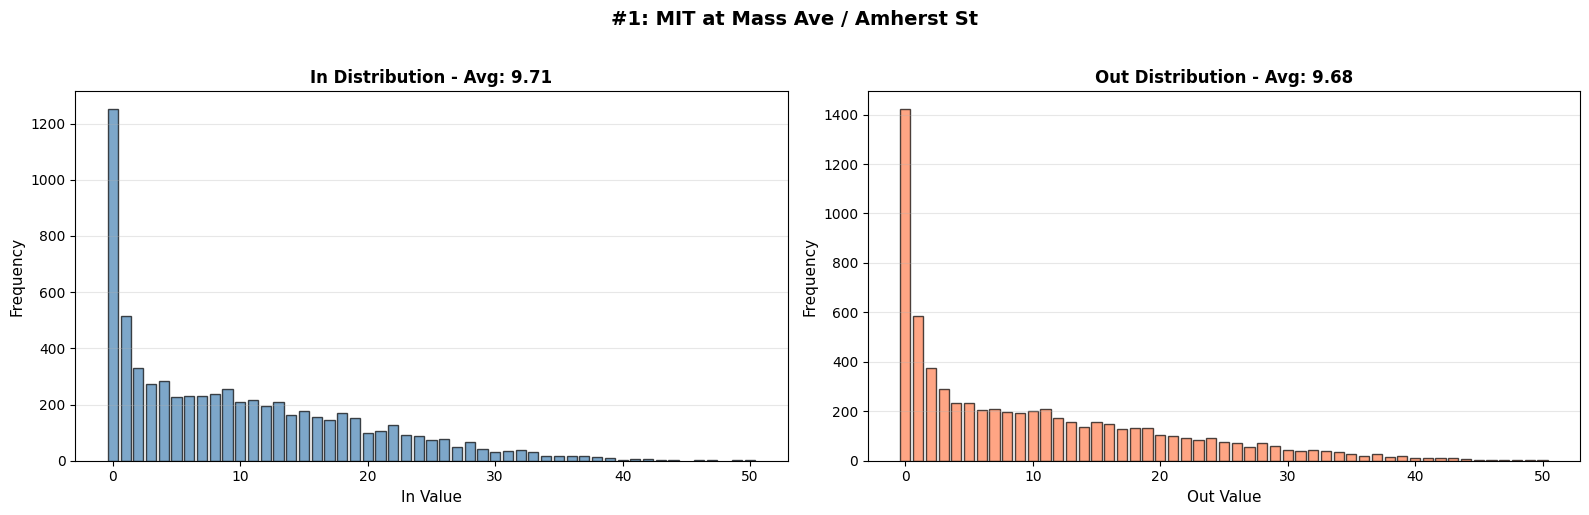

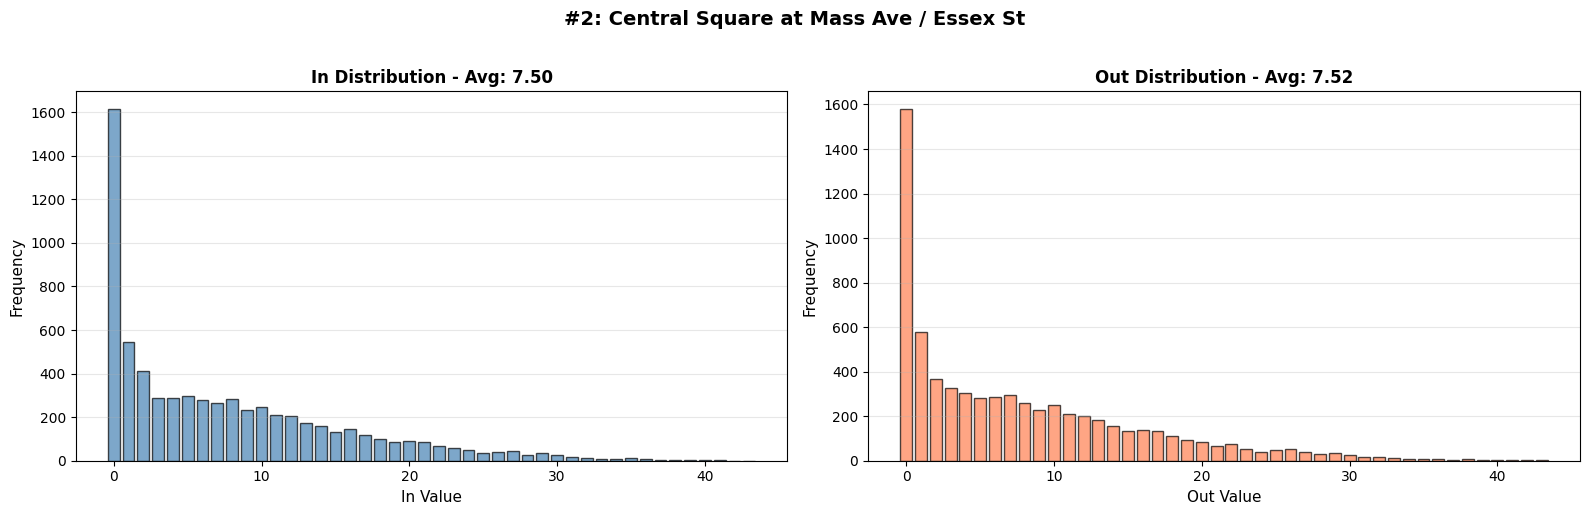

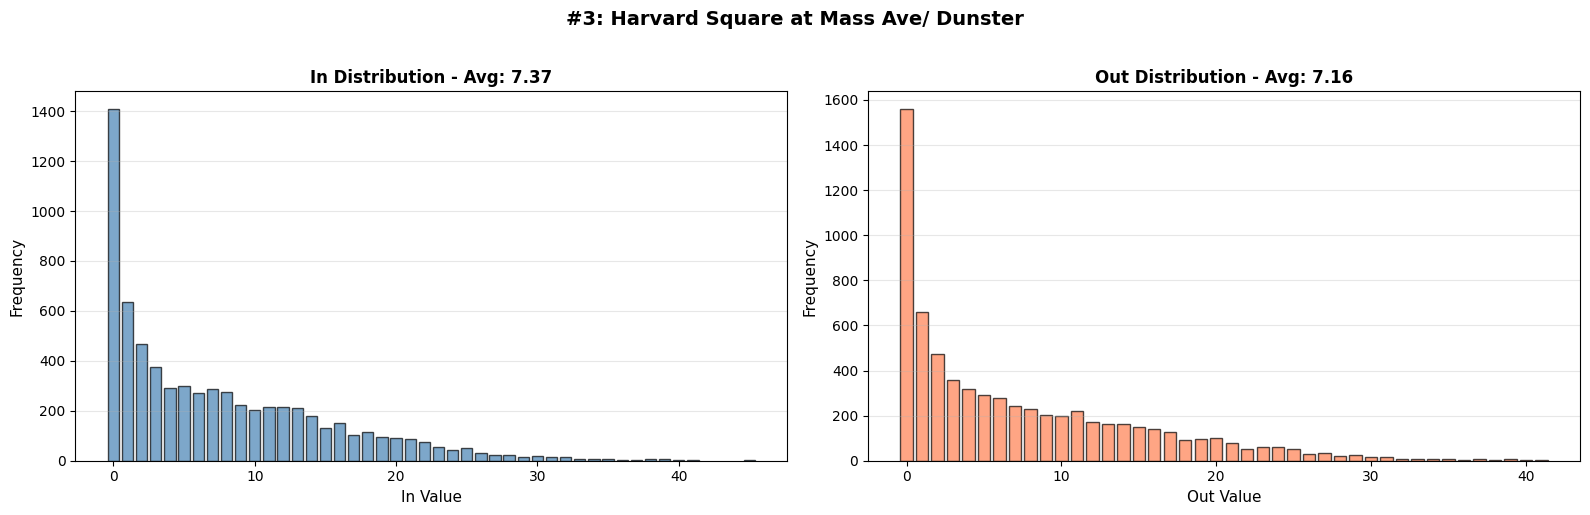

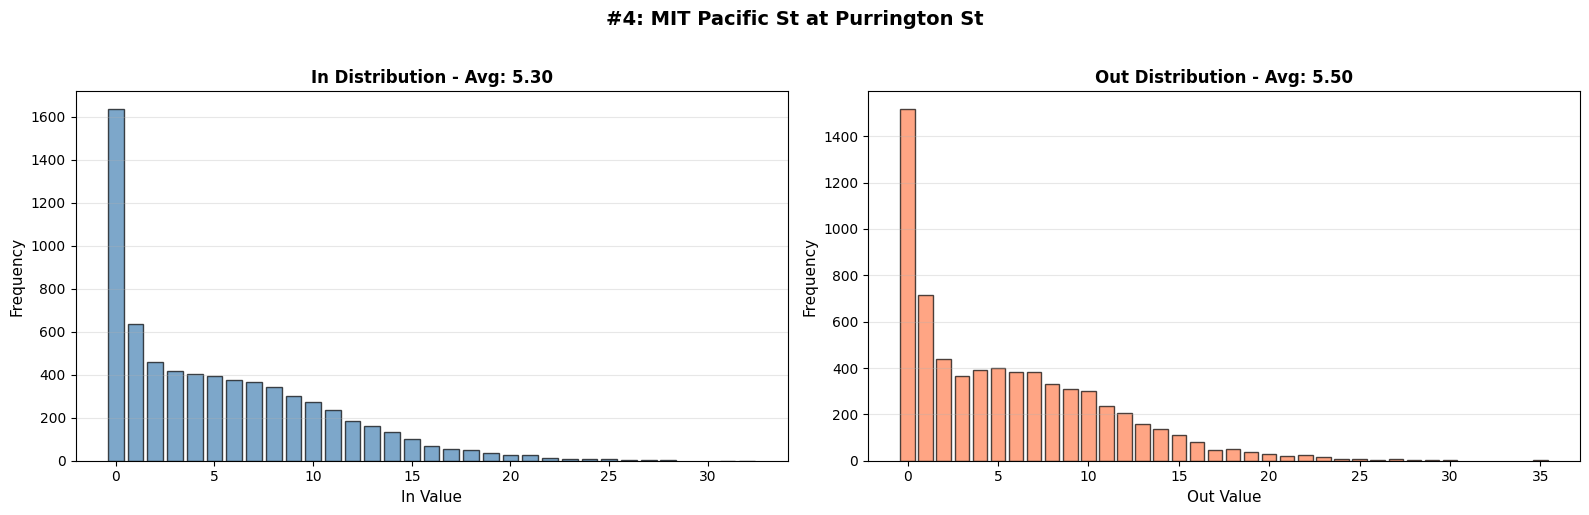

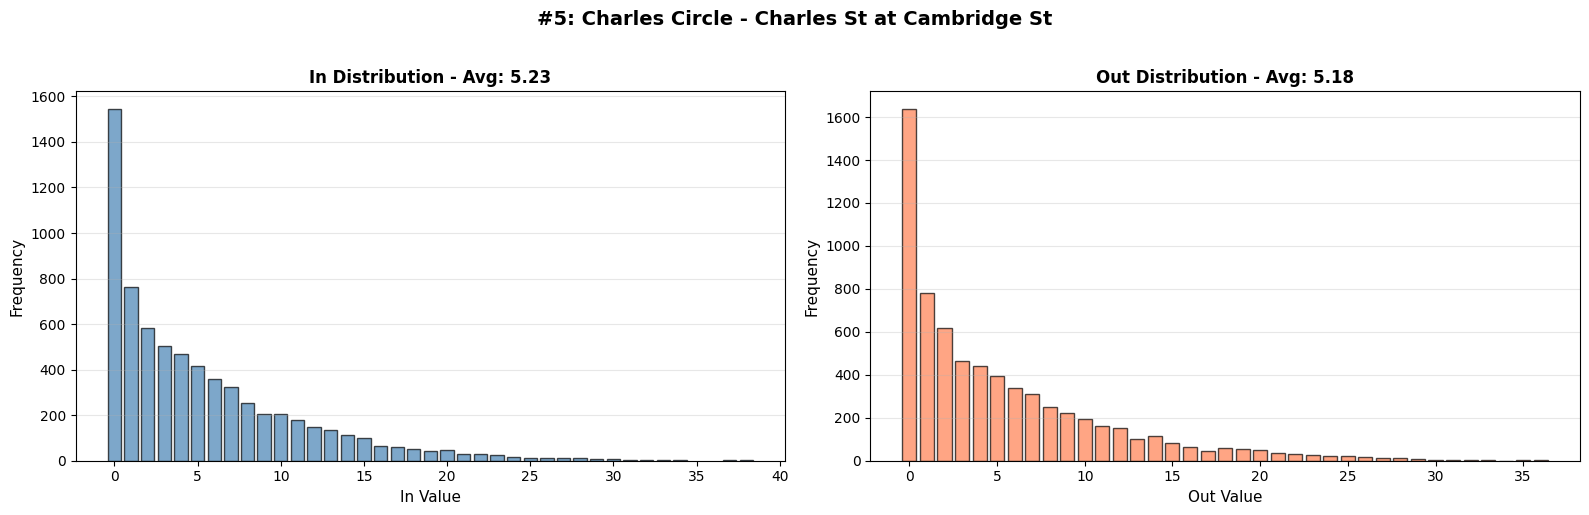

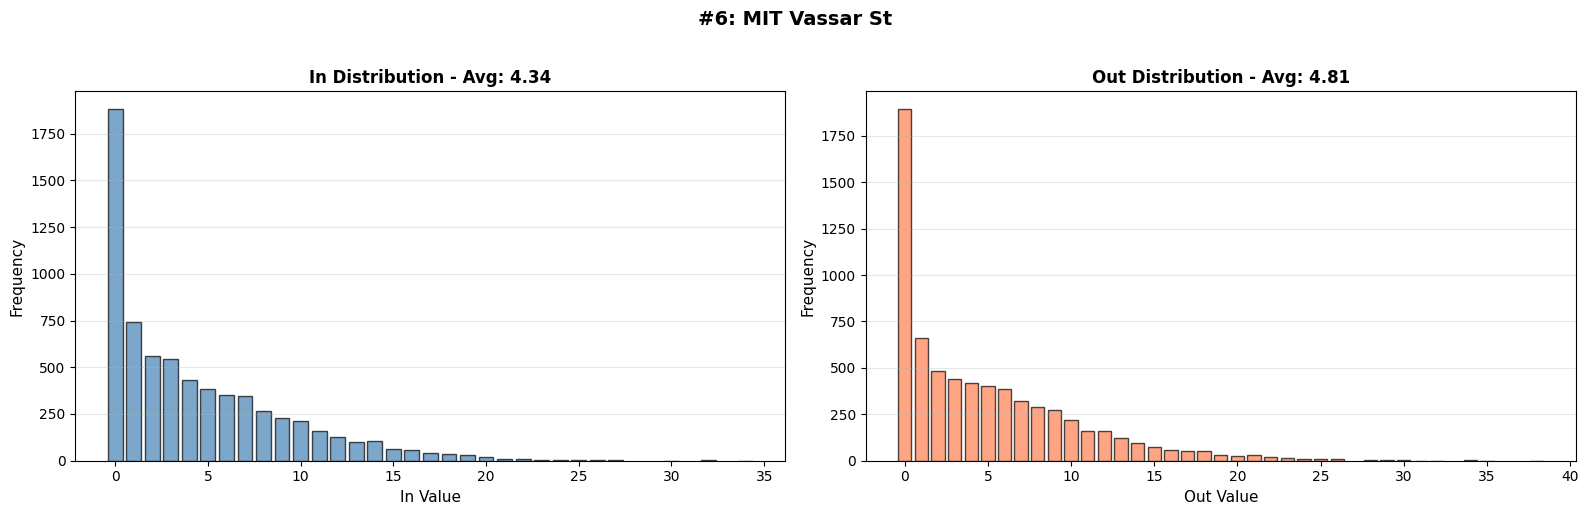

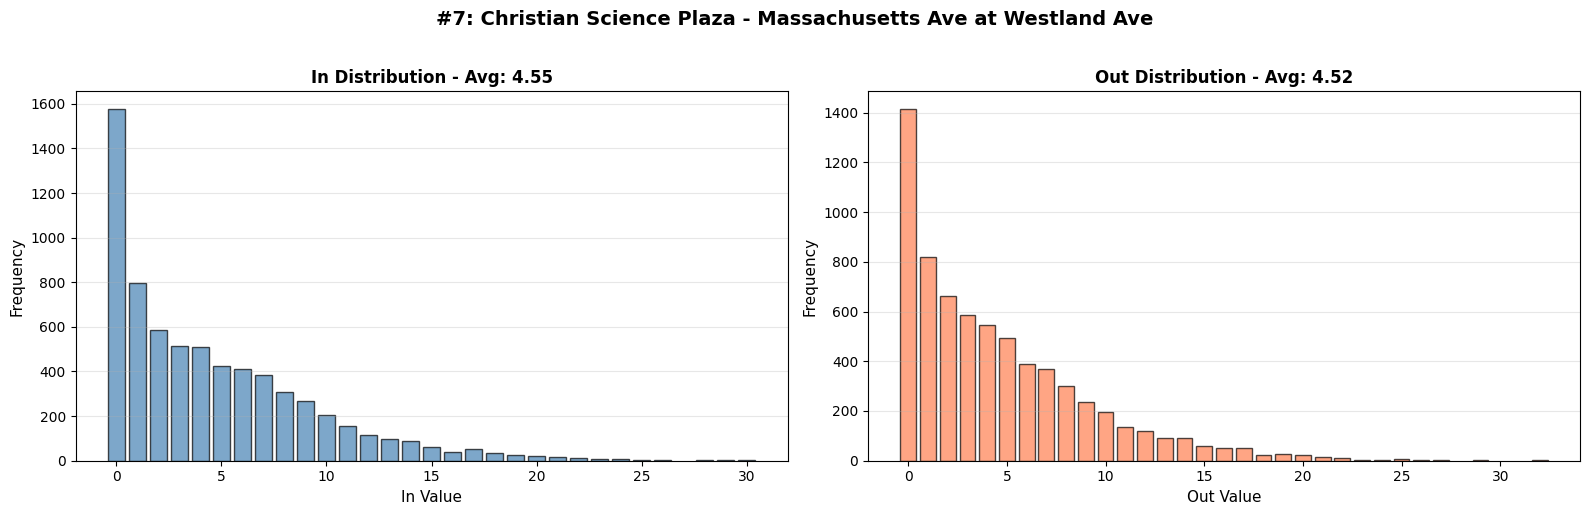

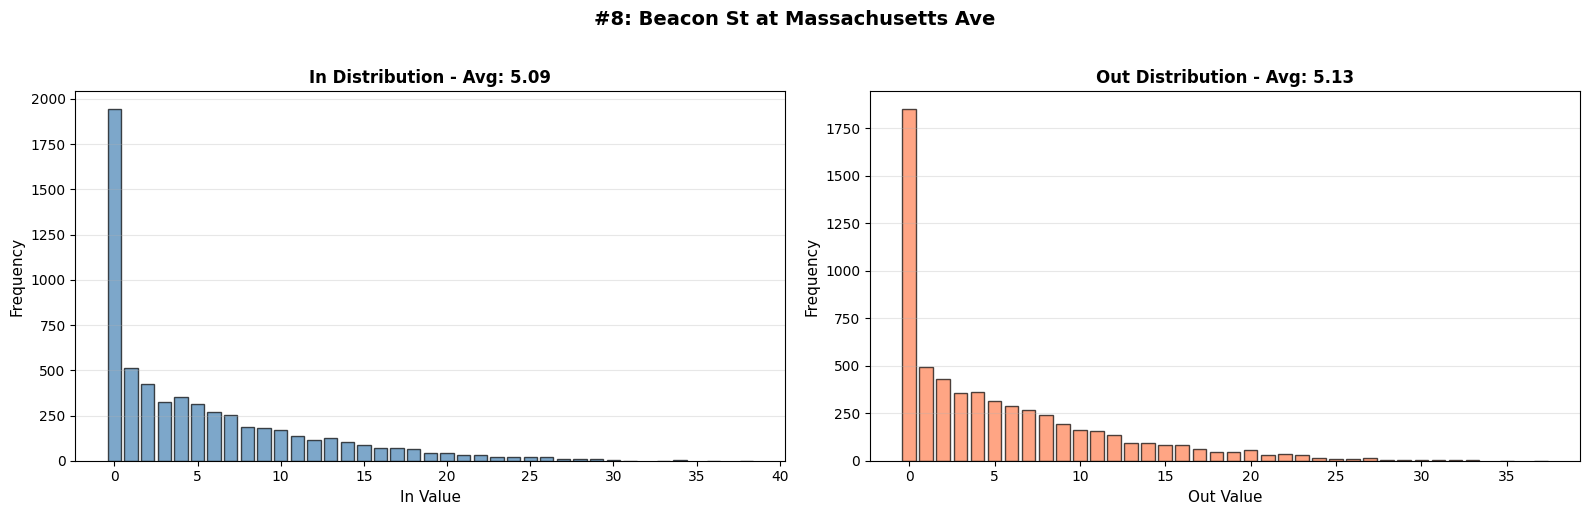

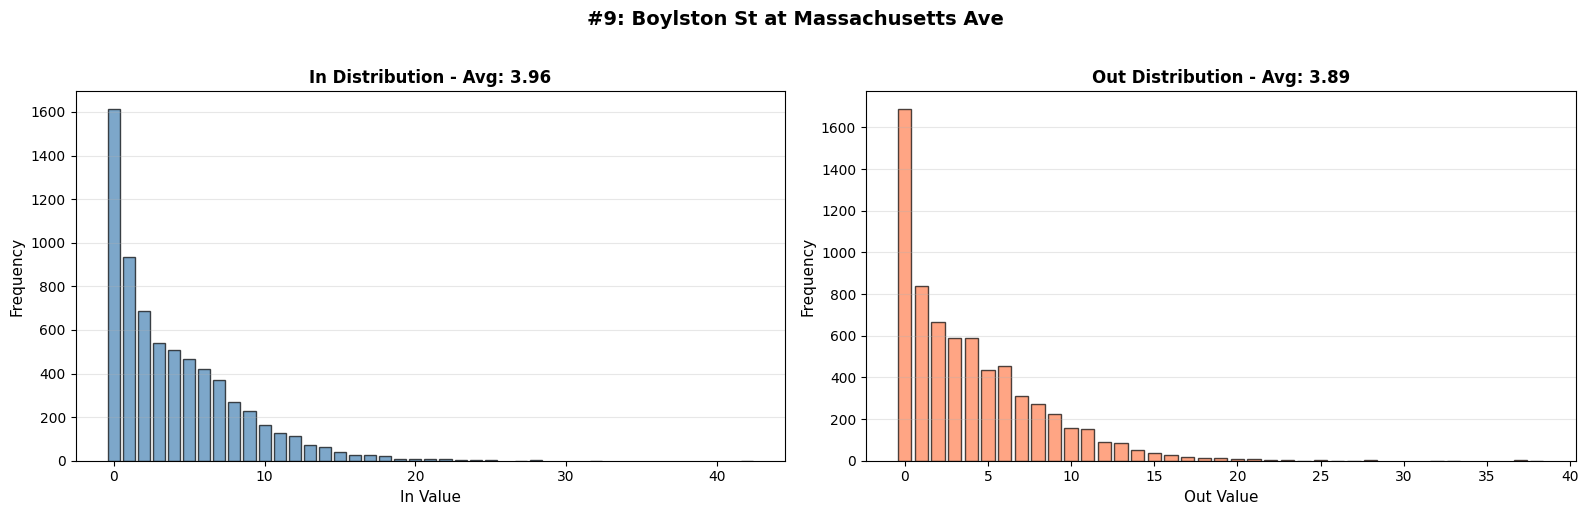

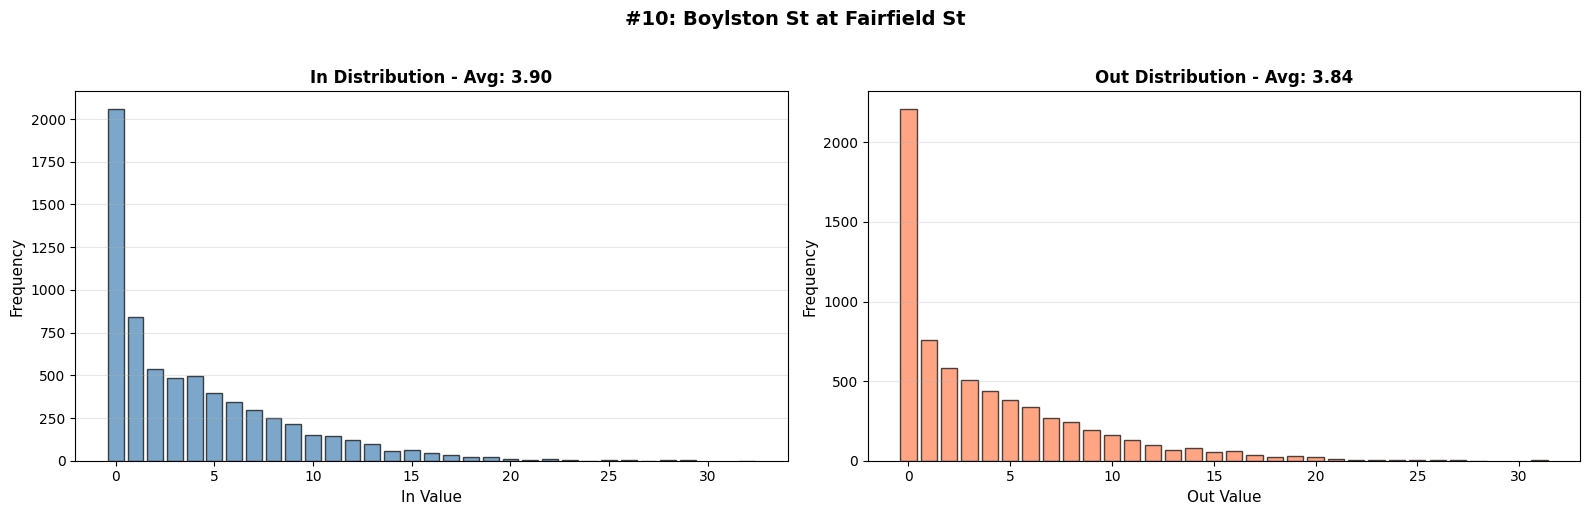

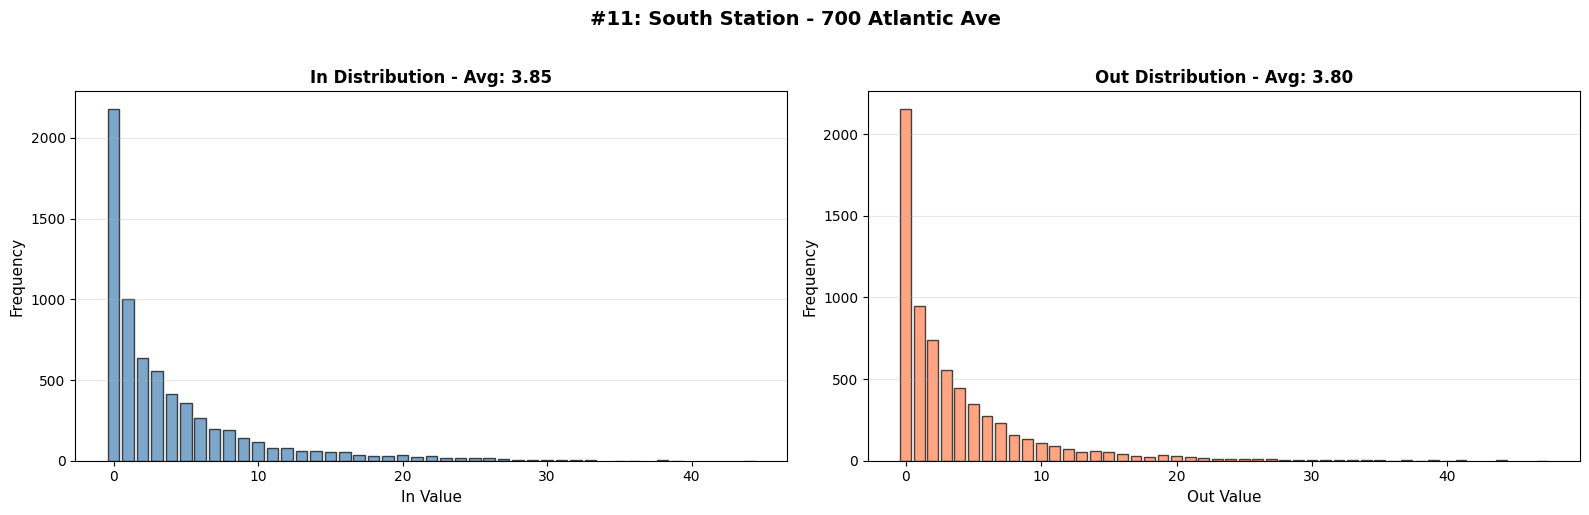

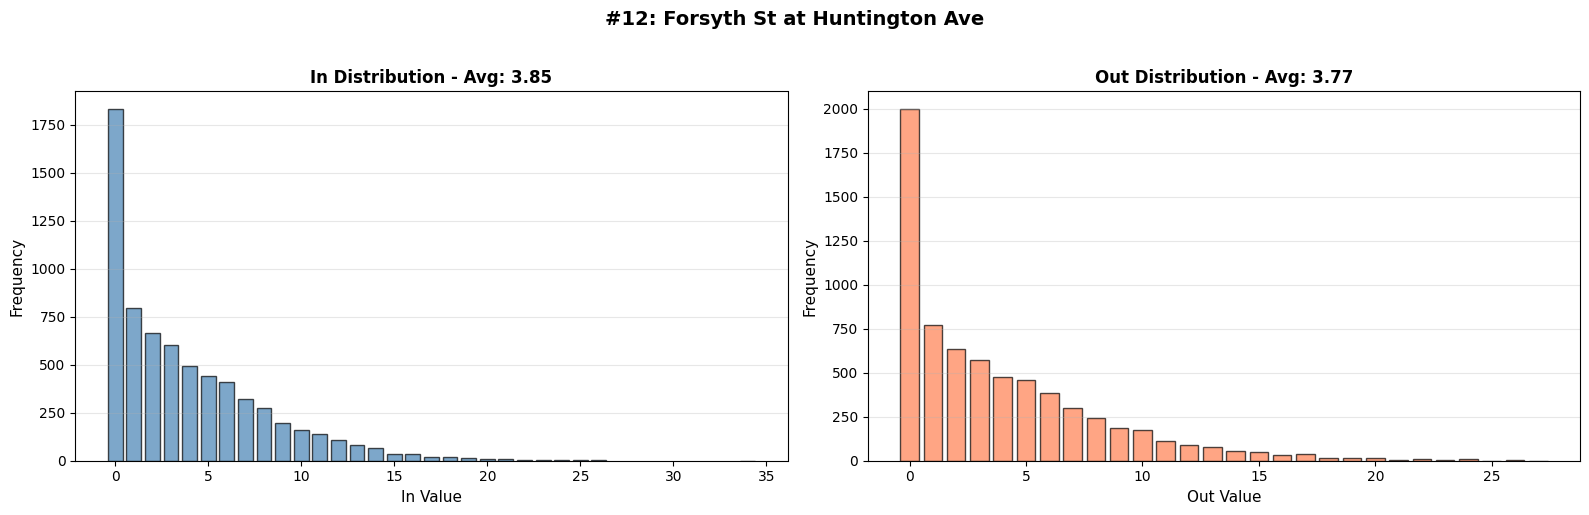

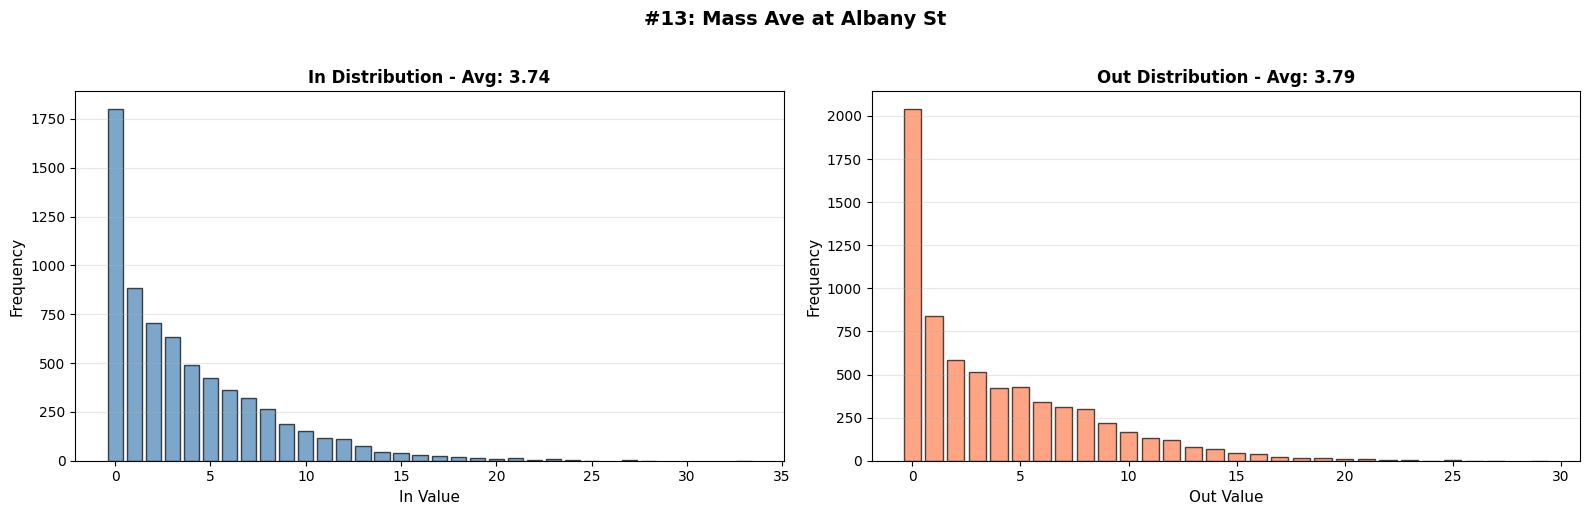

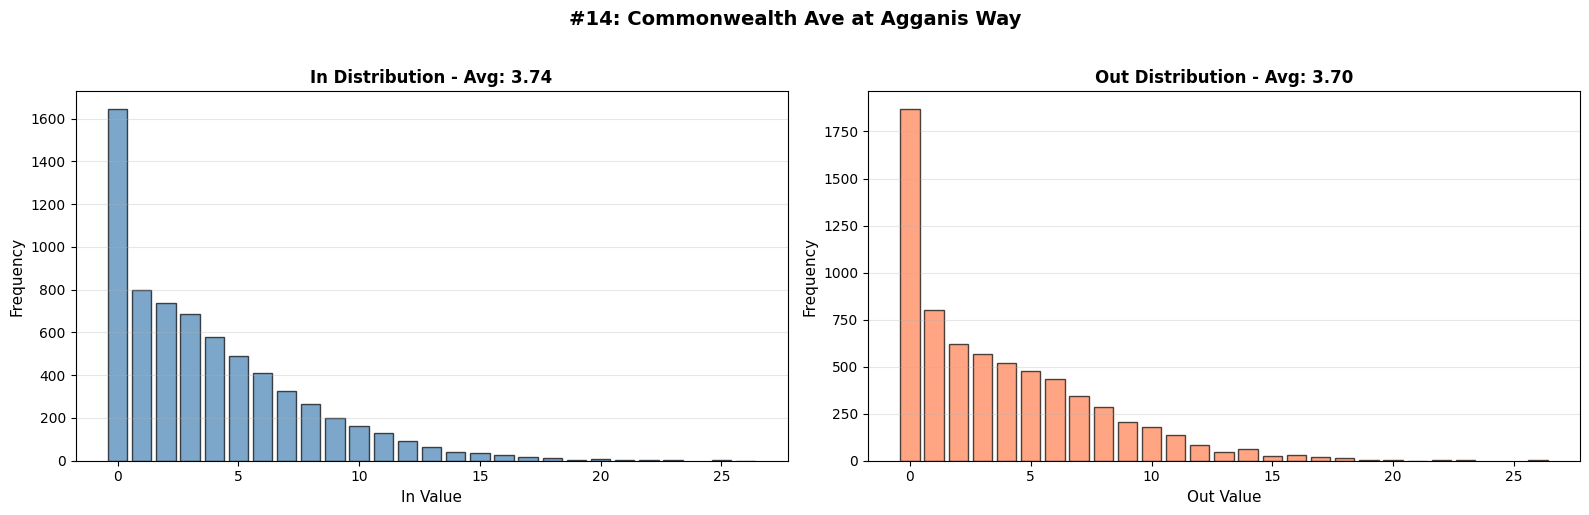

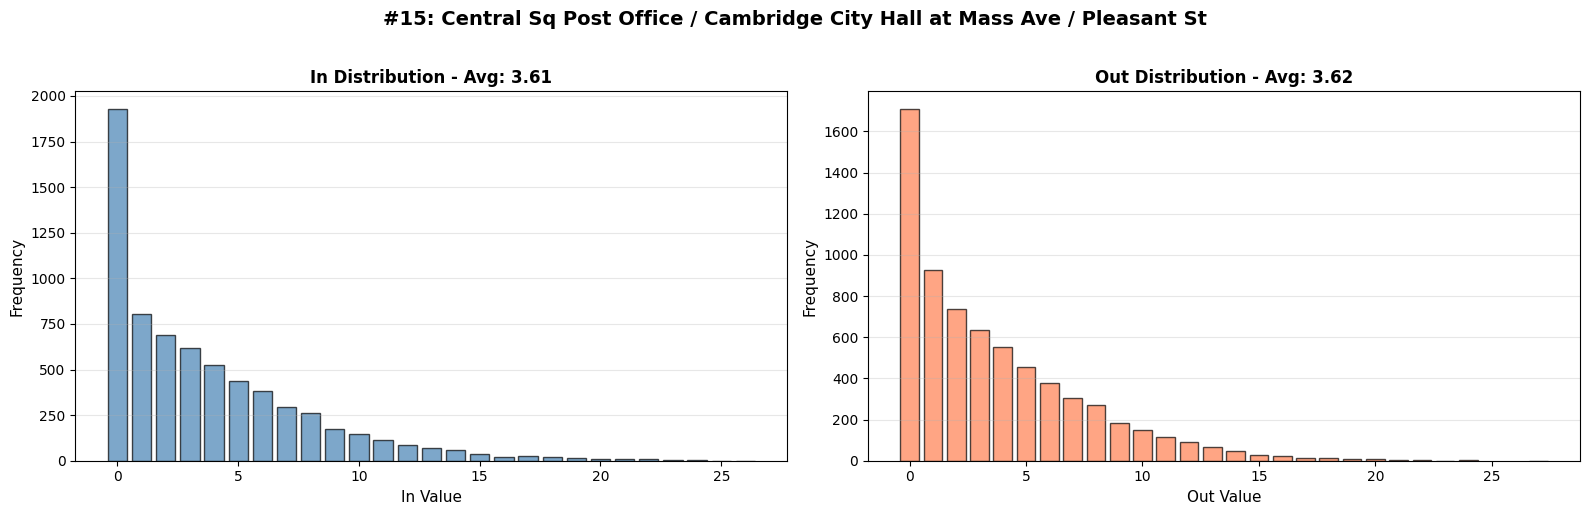

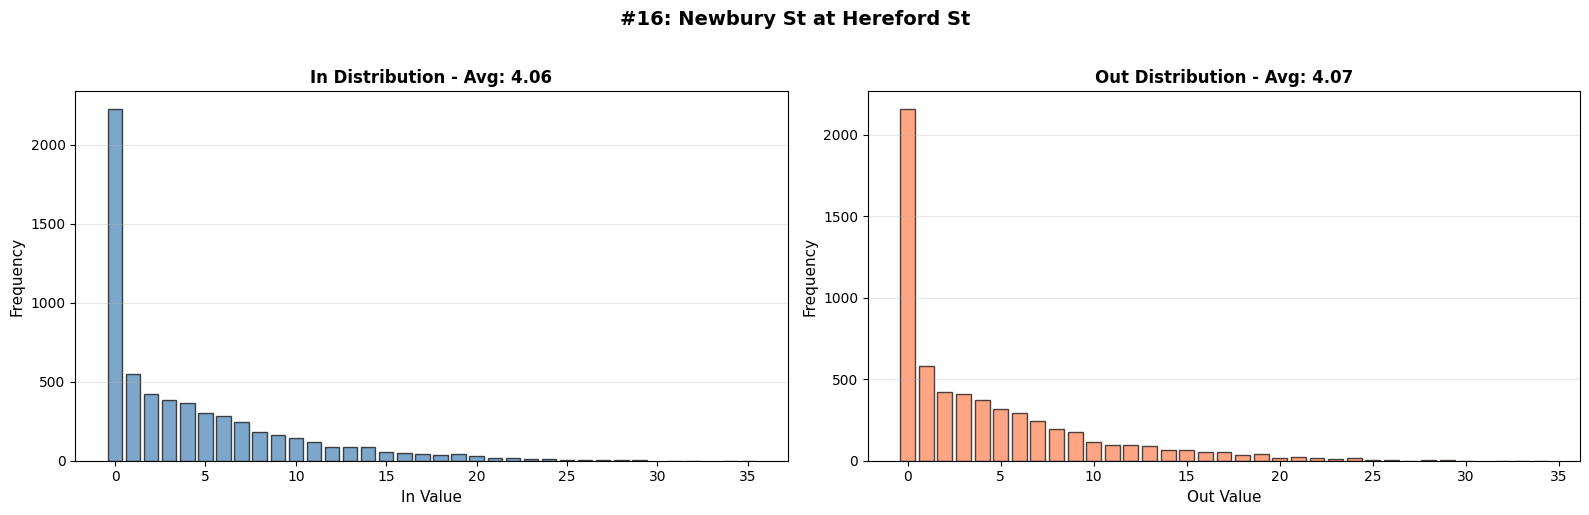

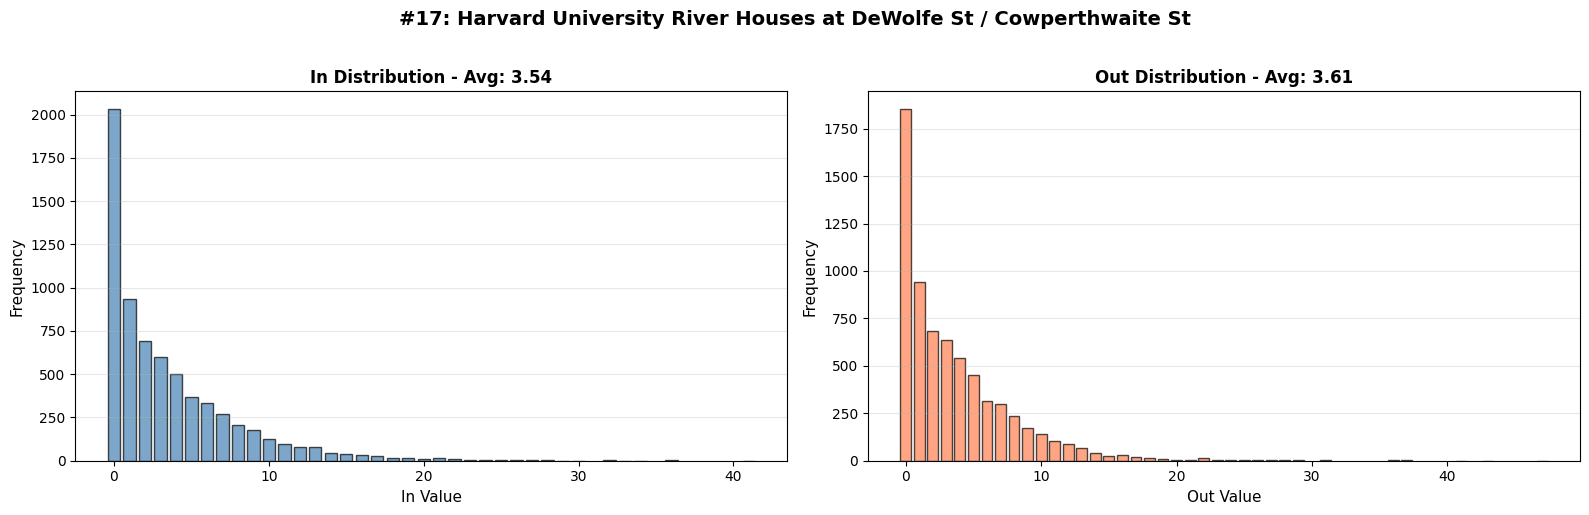

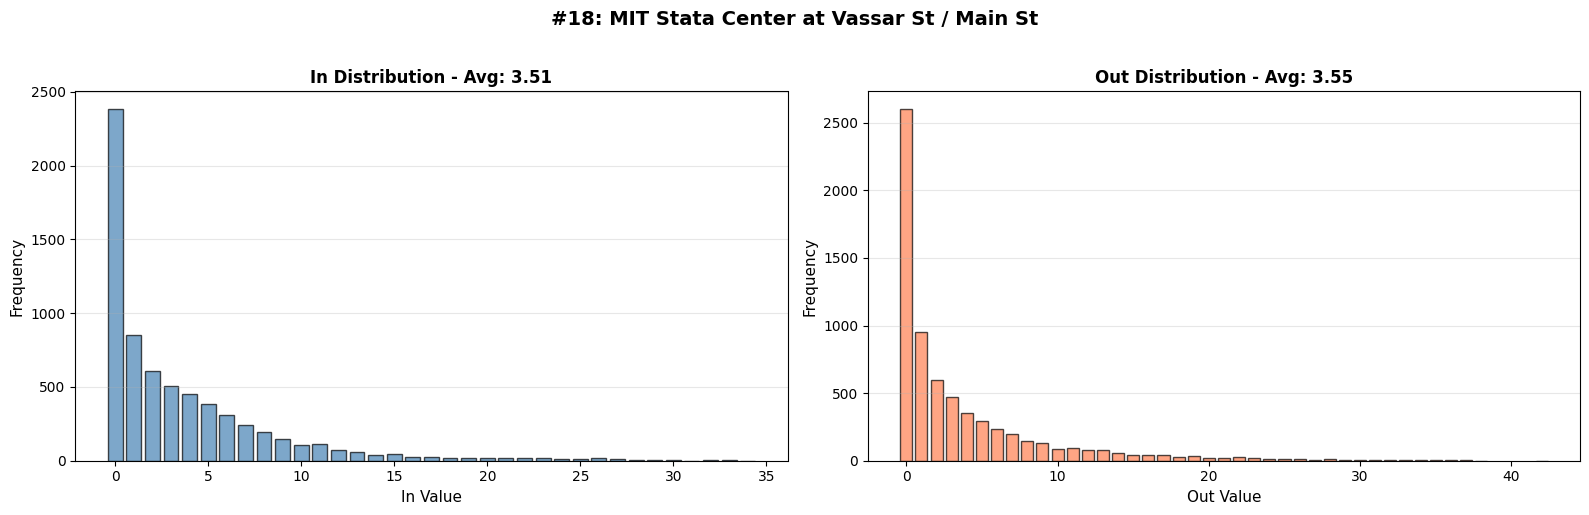

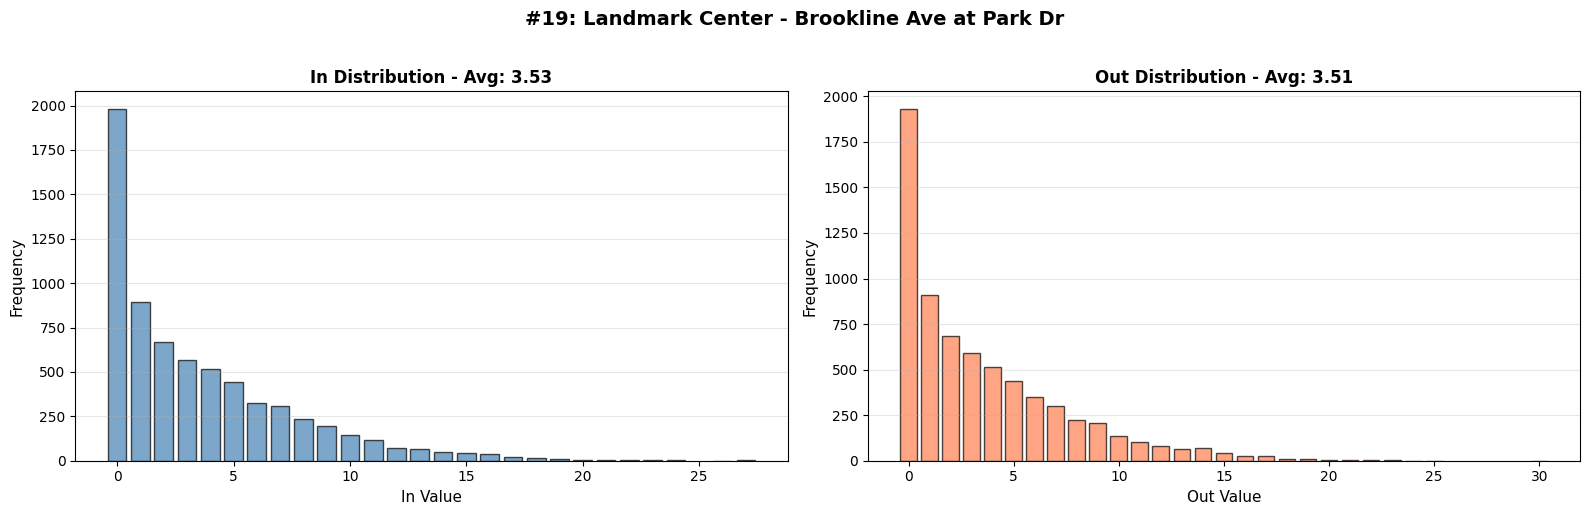

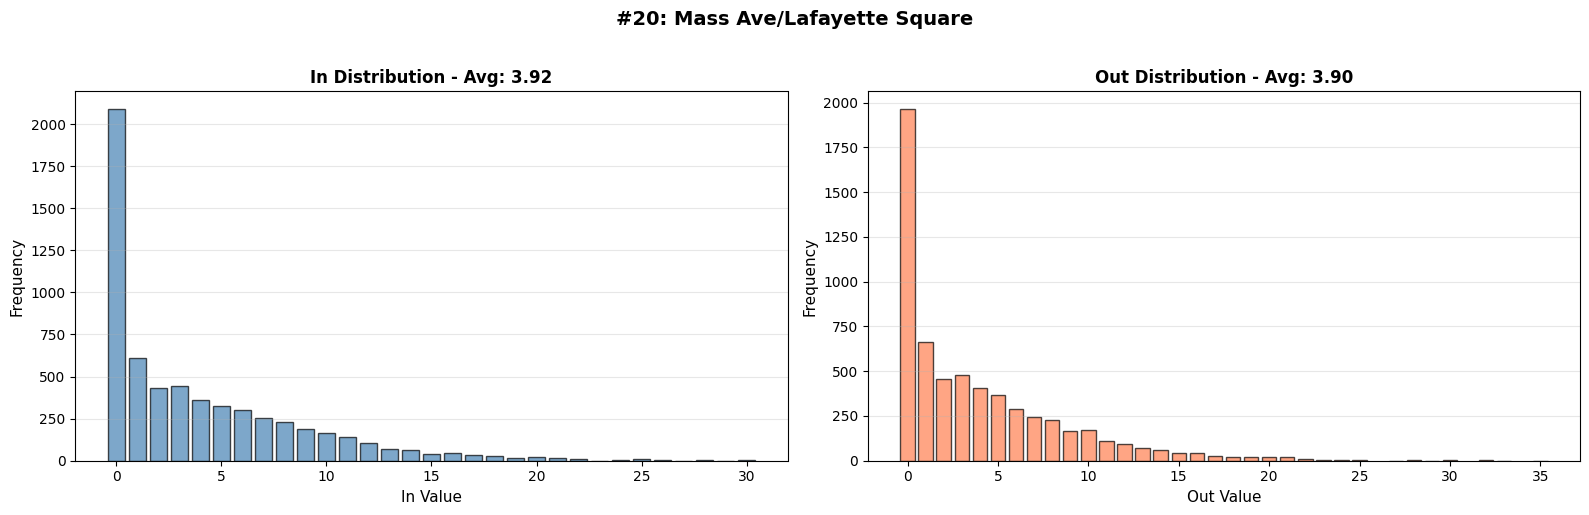

In [127]:
# Filter data to only include top 20 stations
top_20_station_names = top_20_stations['station_name'].tolist()
df_top_20 = df_transformed[df_transformed['station_name'].isin(top_20_station_names)].copy()

# Calculate average in and out values per hour for each station
avg_stats = df_top_20.groupby('station_name').agg({
    'in': 'mean',
    'out': 'mean'
}).reset_index()
avg_stats.columns = ['station_name', 'avg_in_per_hour', 'avg_out_per_hour']

# Plot distribution of in and out values for each of the top 20 stations
for idx, station_name in enumerate(top_20_station_names, 1):
    station_data = df_top_20[df_top_20['station_name'] == station_name]
    
    # Calculate distributions
    in_dist = station_data['in'].value_counts().sort_index()
    out_dist = station_data['out'].value_counts().sort_index()
    
    # Get average values for title
    avg_in = station_data['in'].mean()
    avg_out = station_data['out'].mean()
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot In distribution
    ax1.bar(in_dist.index, in_dist.values, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('In Value', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title(f'In Distribution - Avg: {avg_in:.2f}', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot Out distribution
    ax2.bar(out_dist.index, out_dist.values, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Out Value', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title(f'Out Distribution - Avg: {avg_out:.2f}', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Overall title
    fig.suptitle(f'#{idx}: {station_name}', fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()


Distribution of in and out counts per station (morning and evening rush)

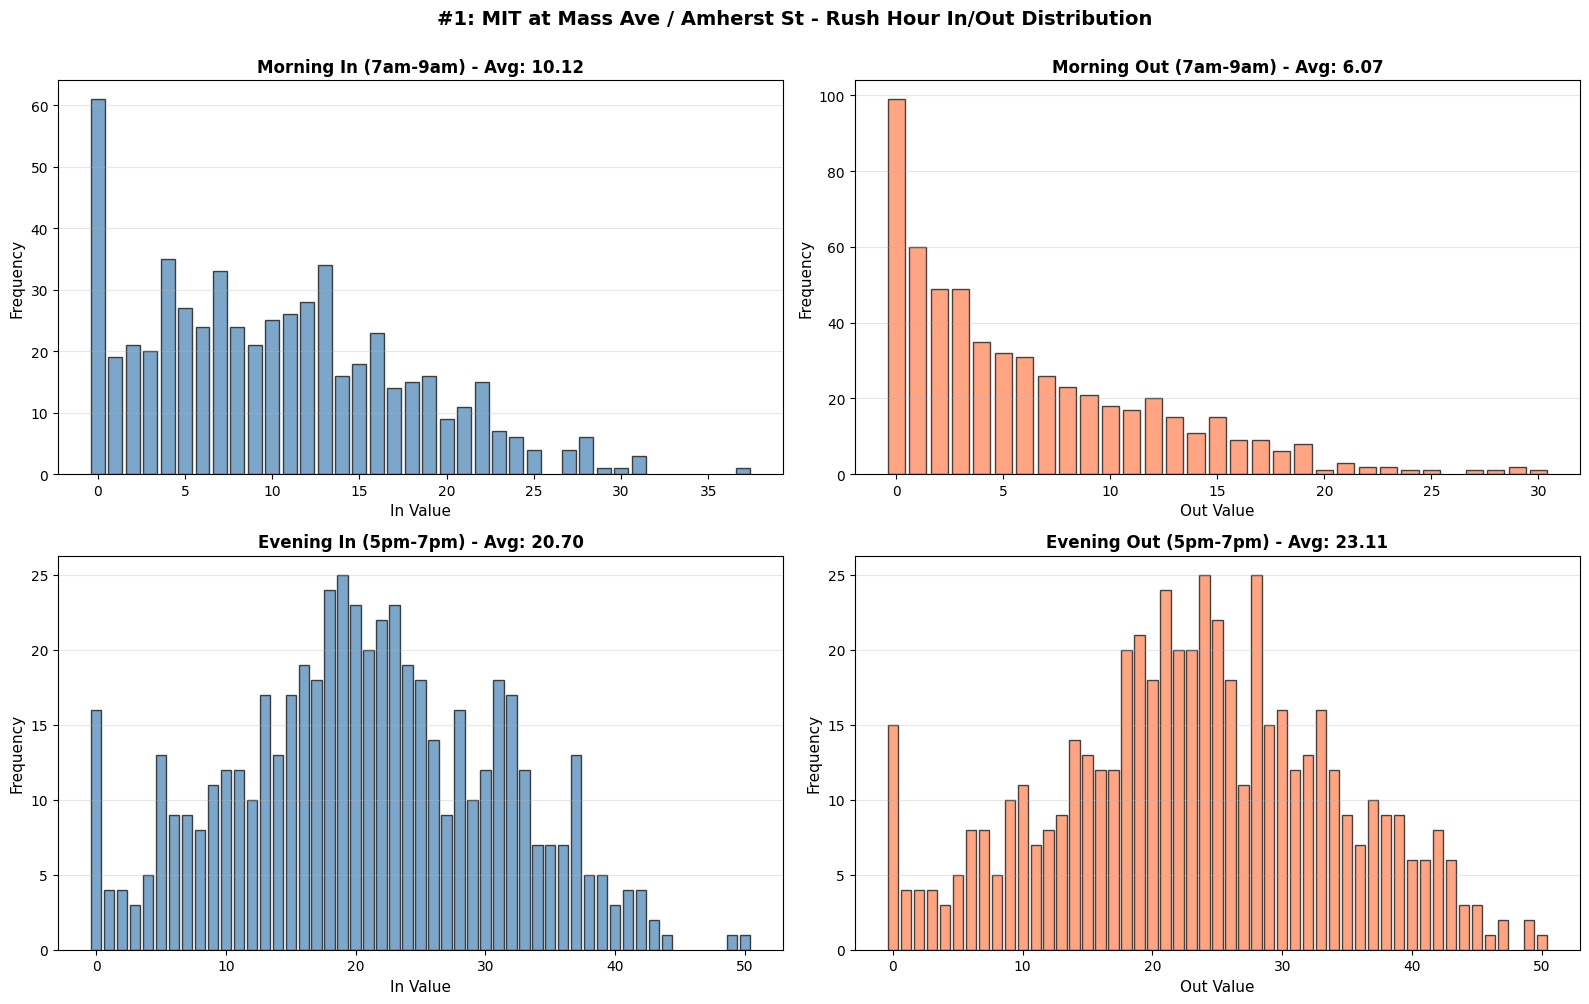

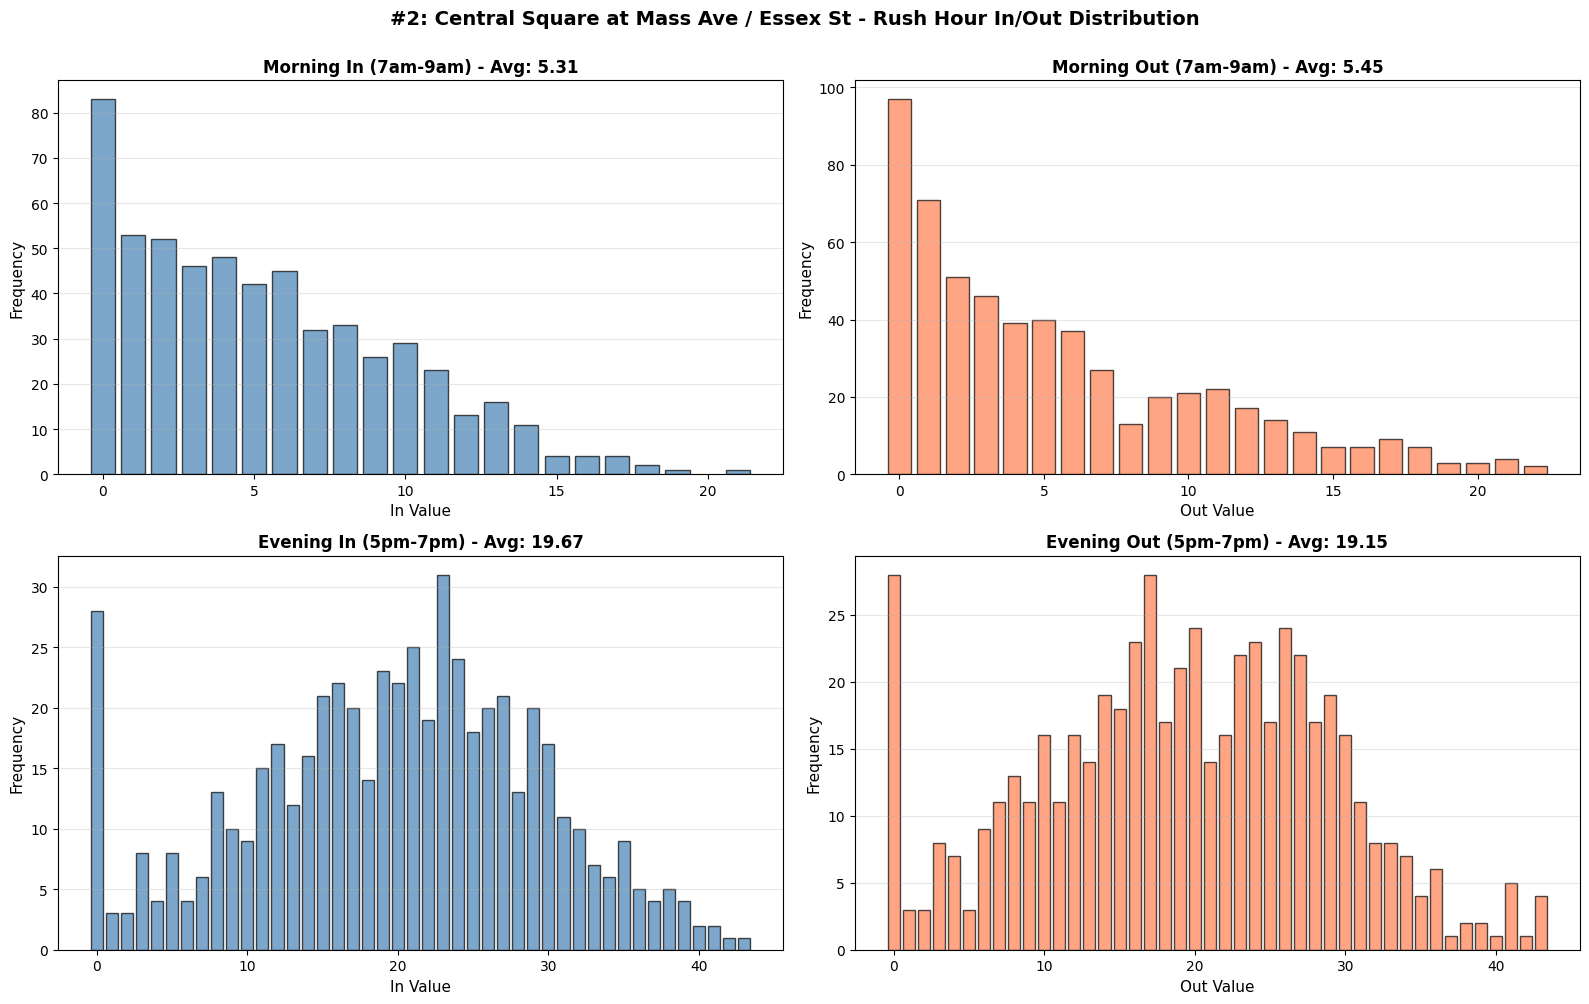

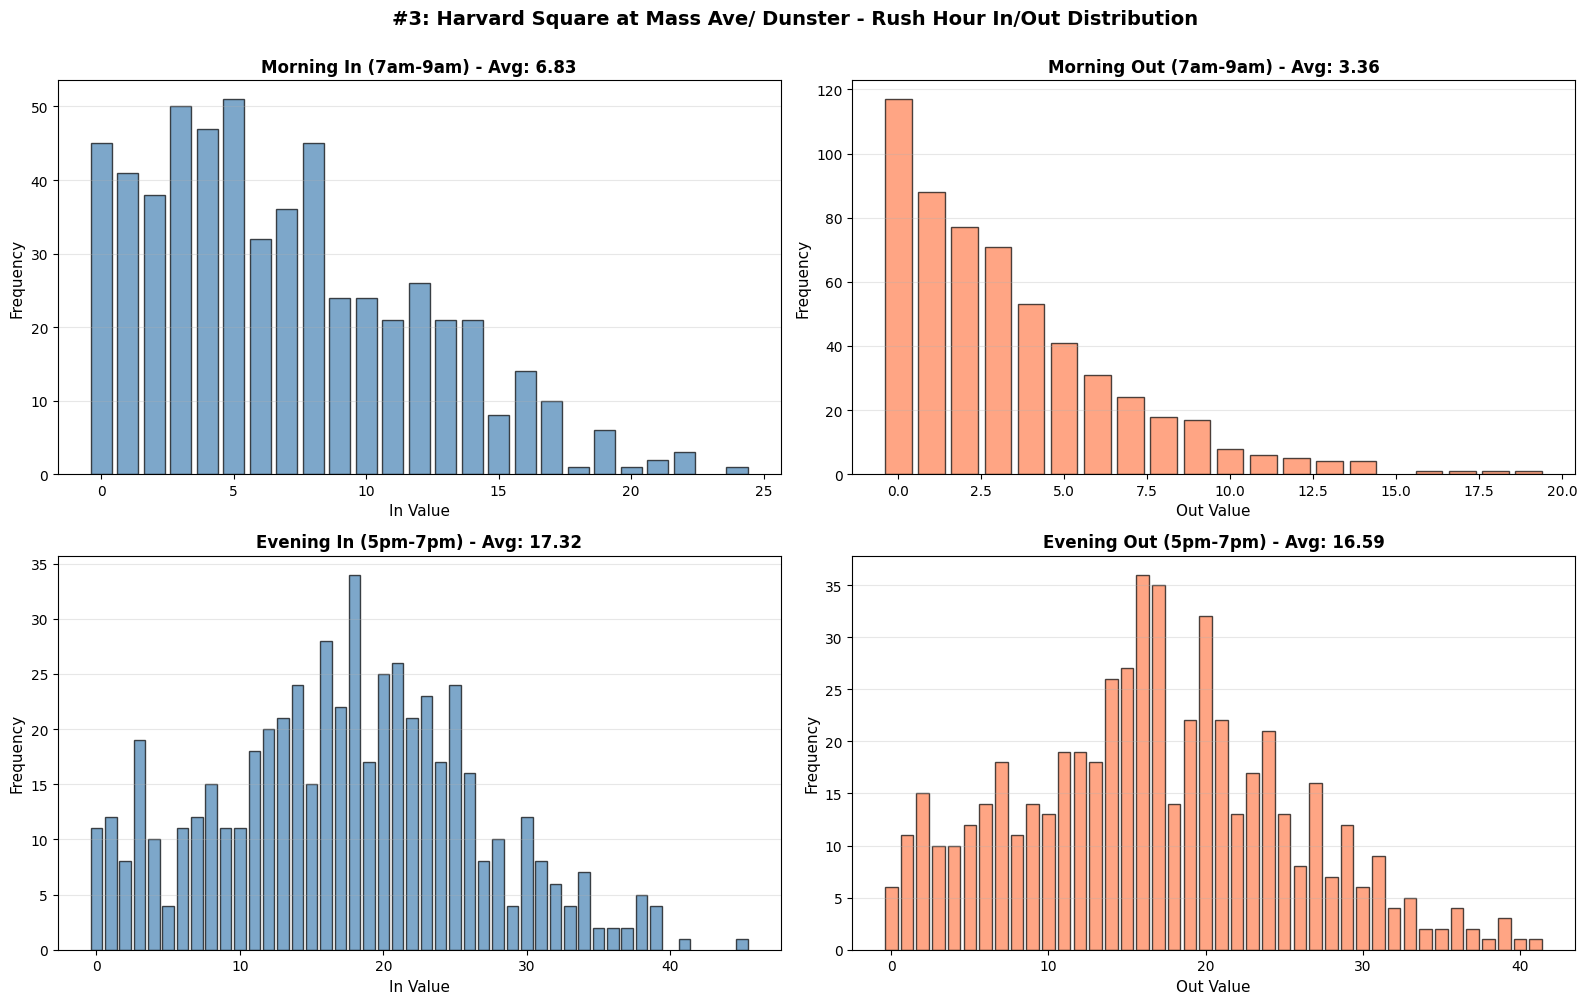

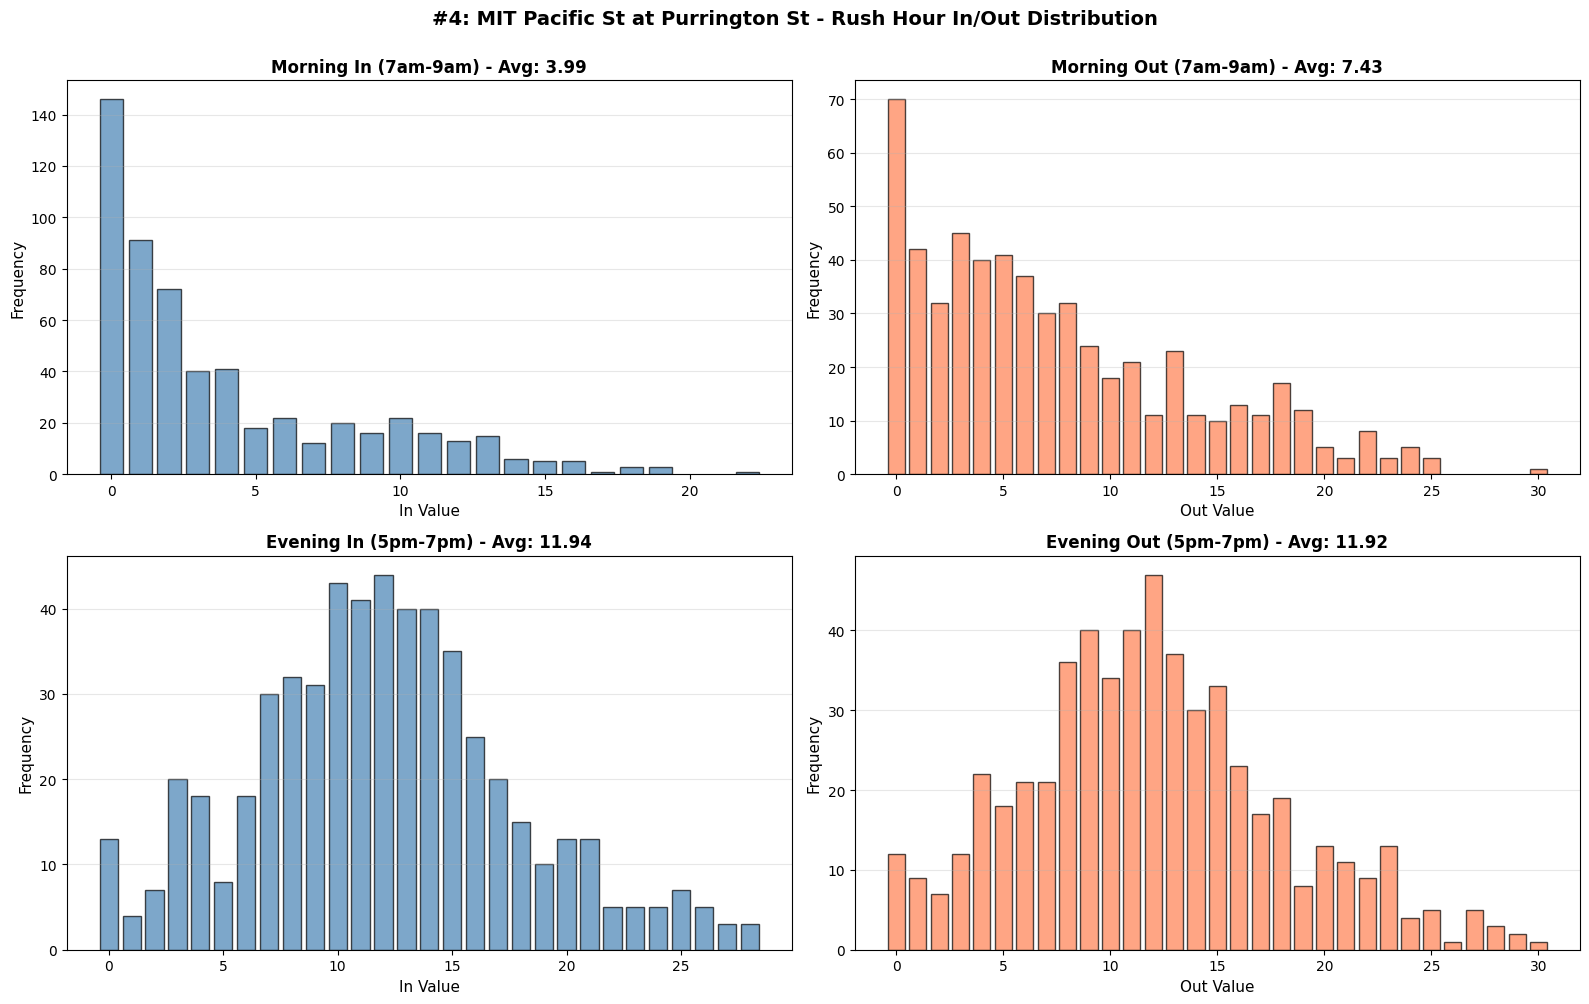

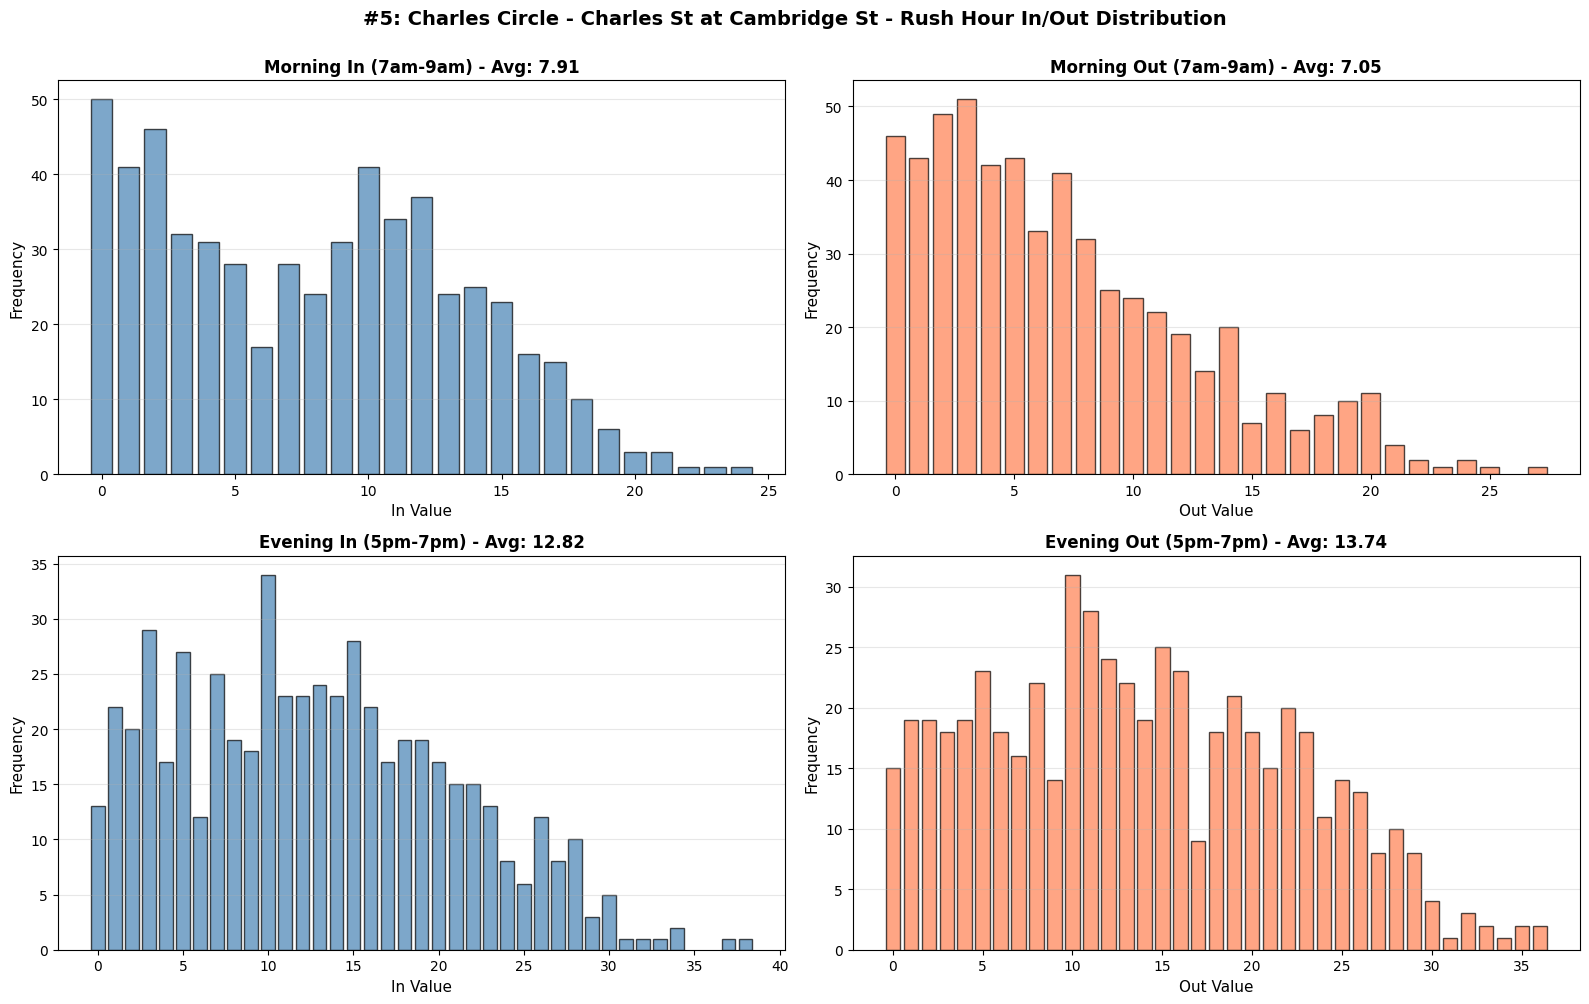

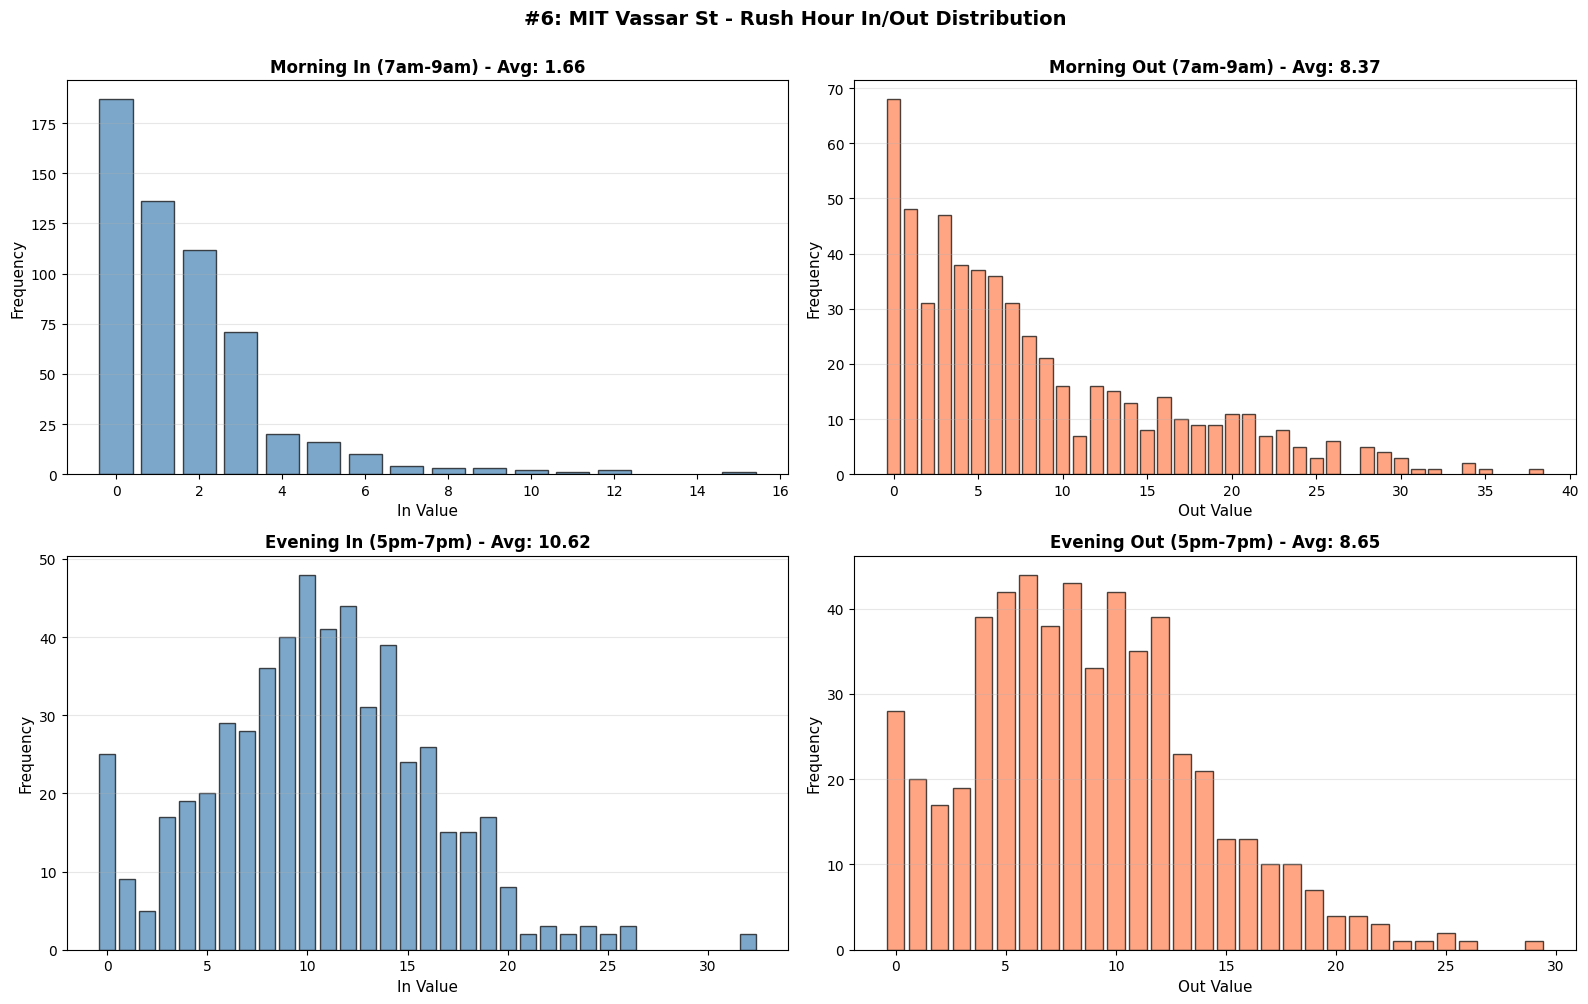

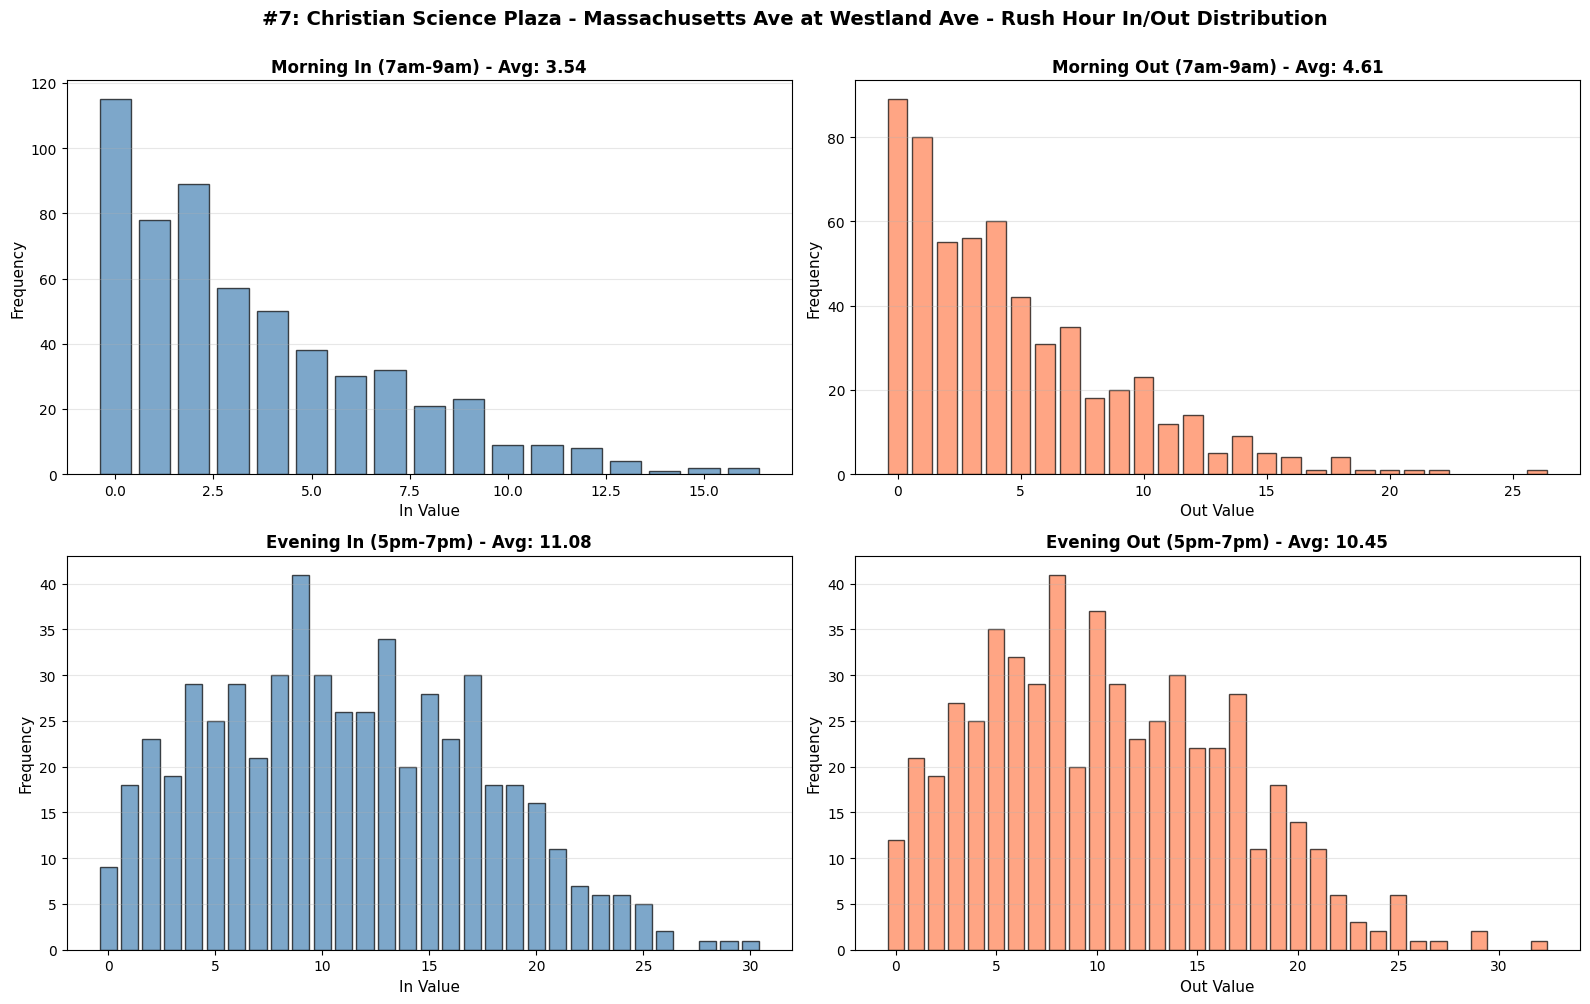

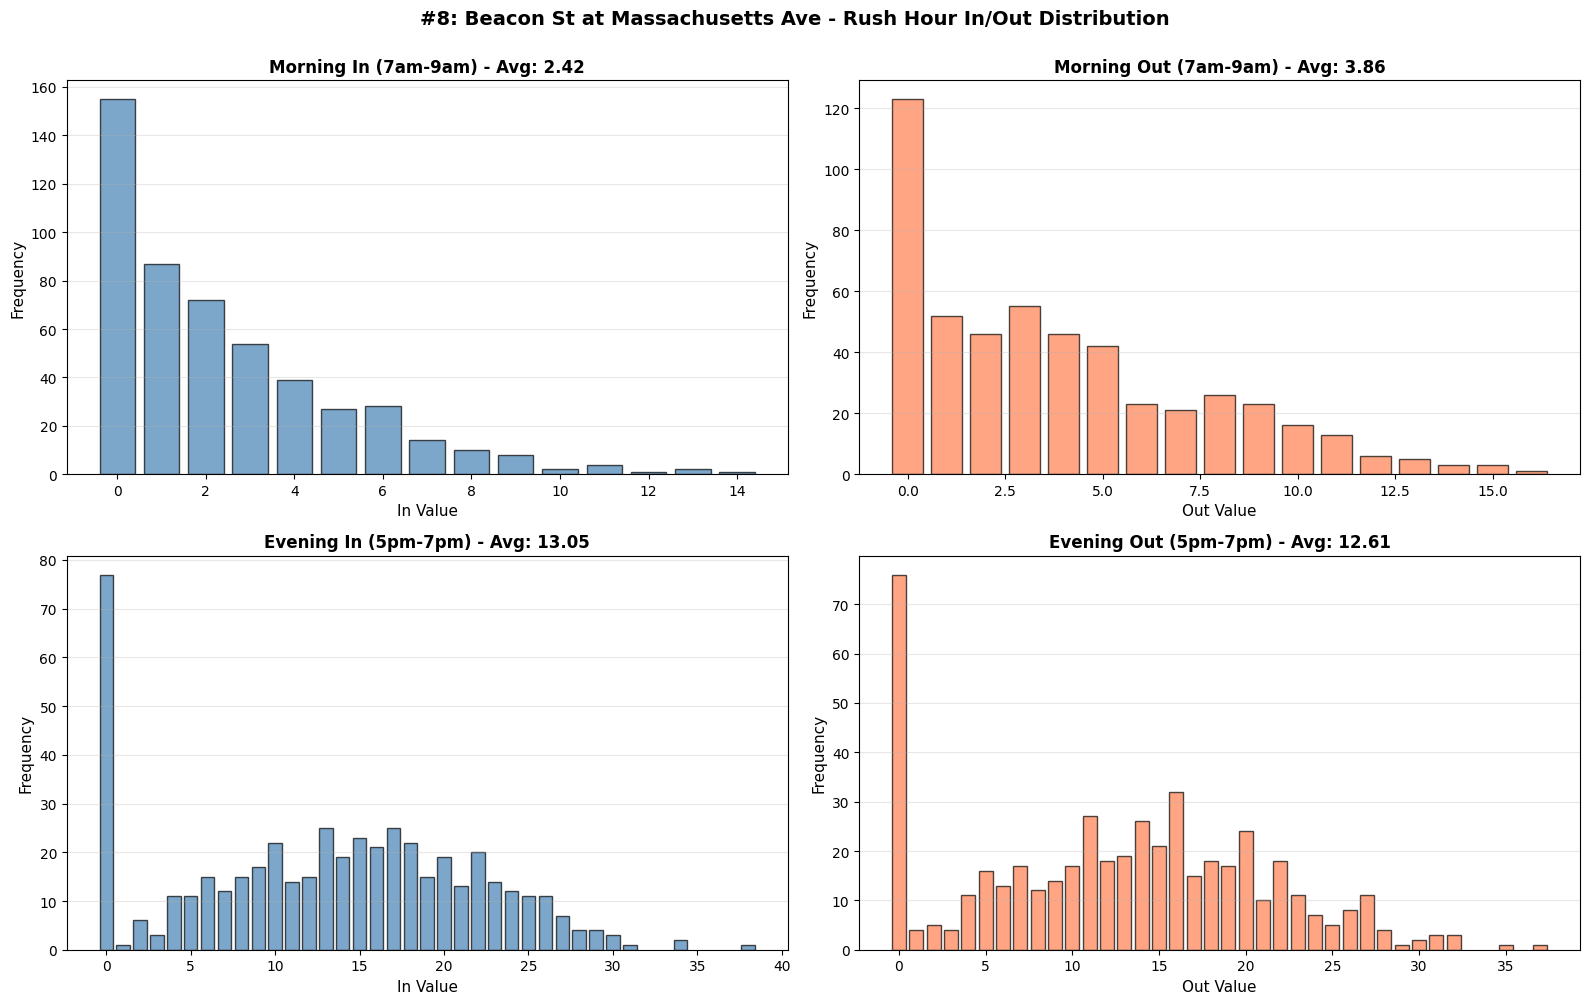

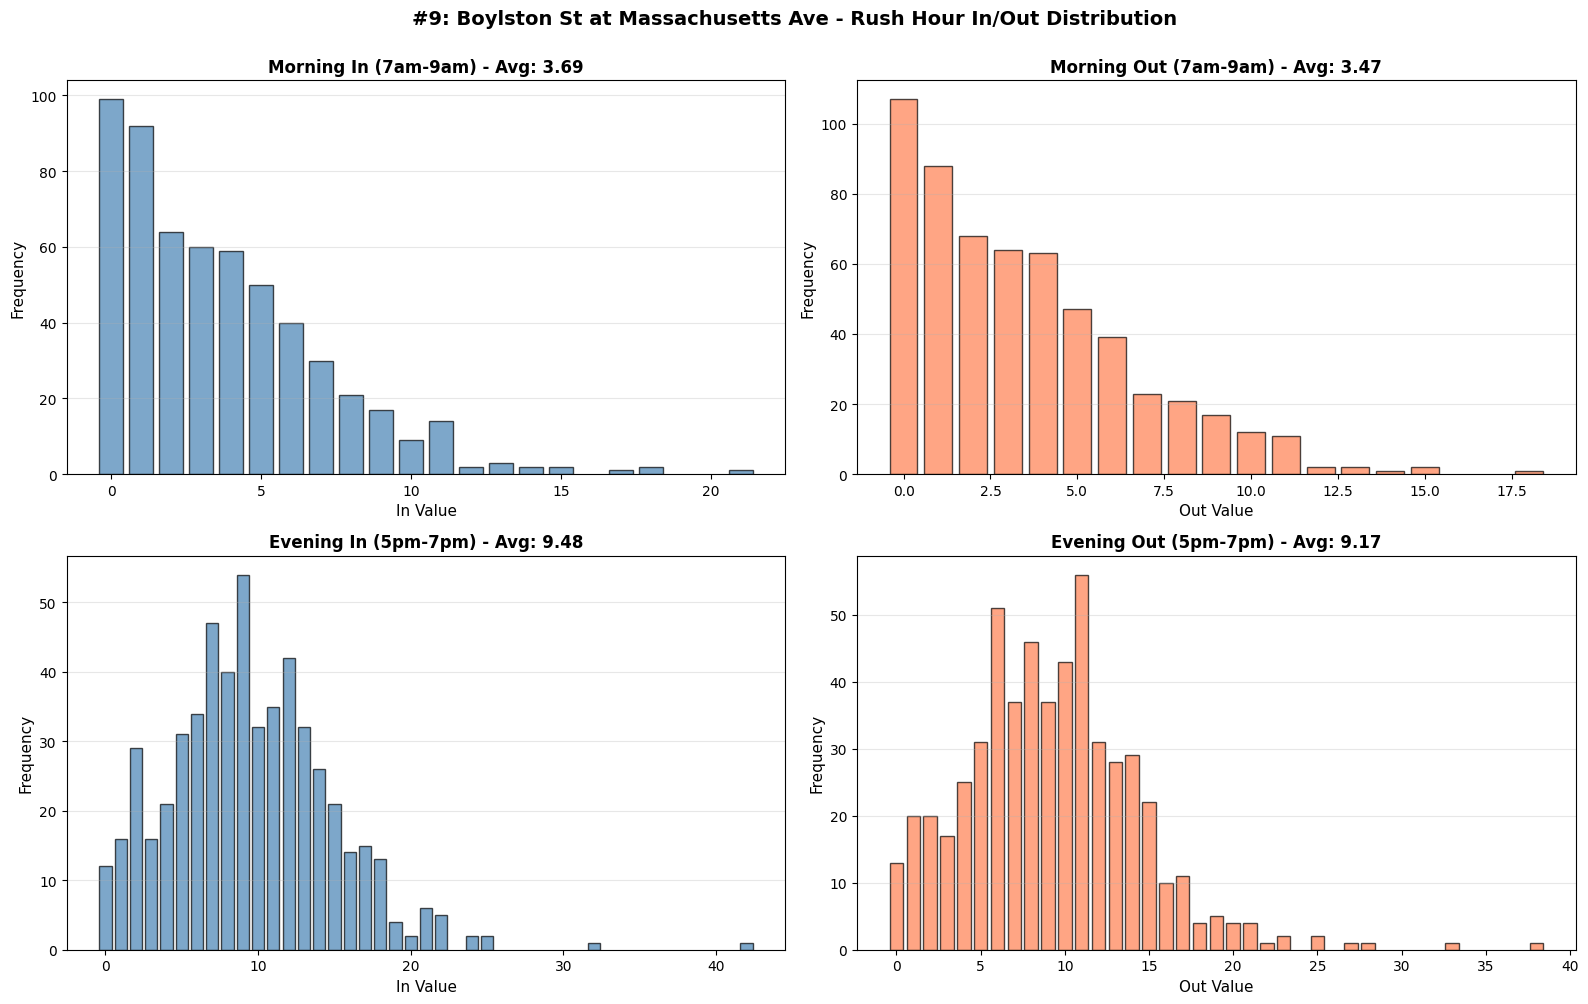

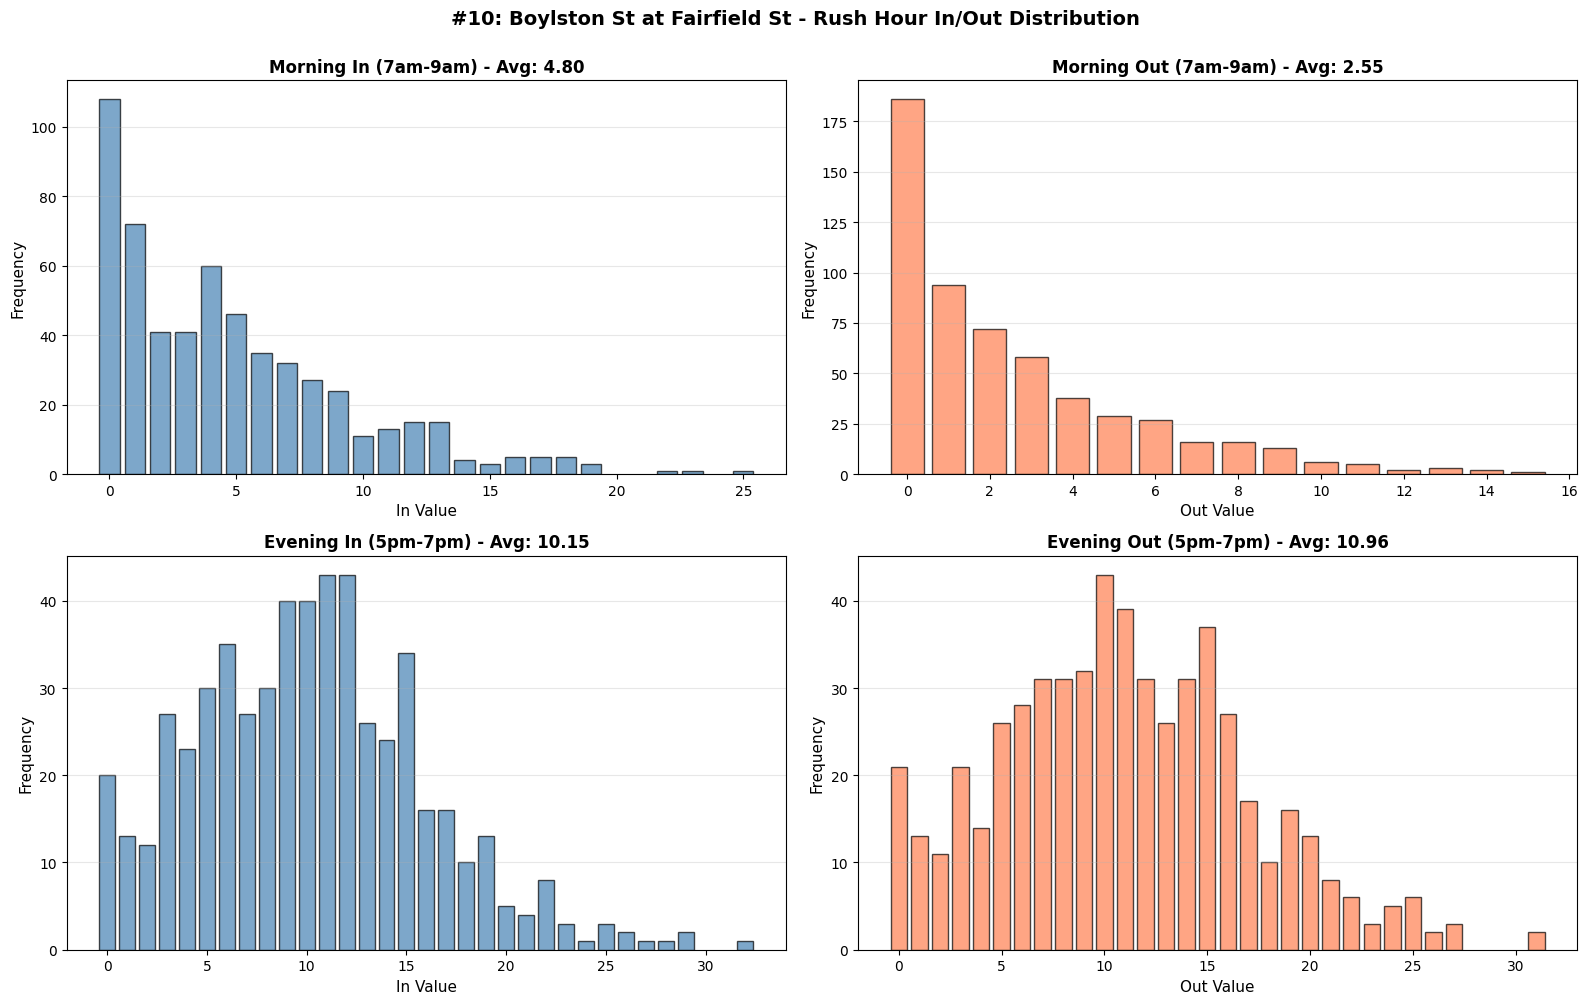

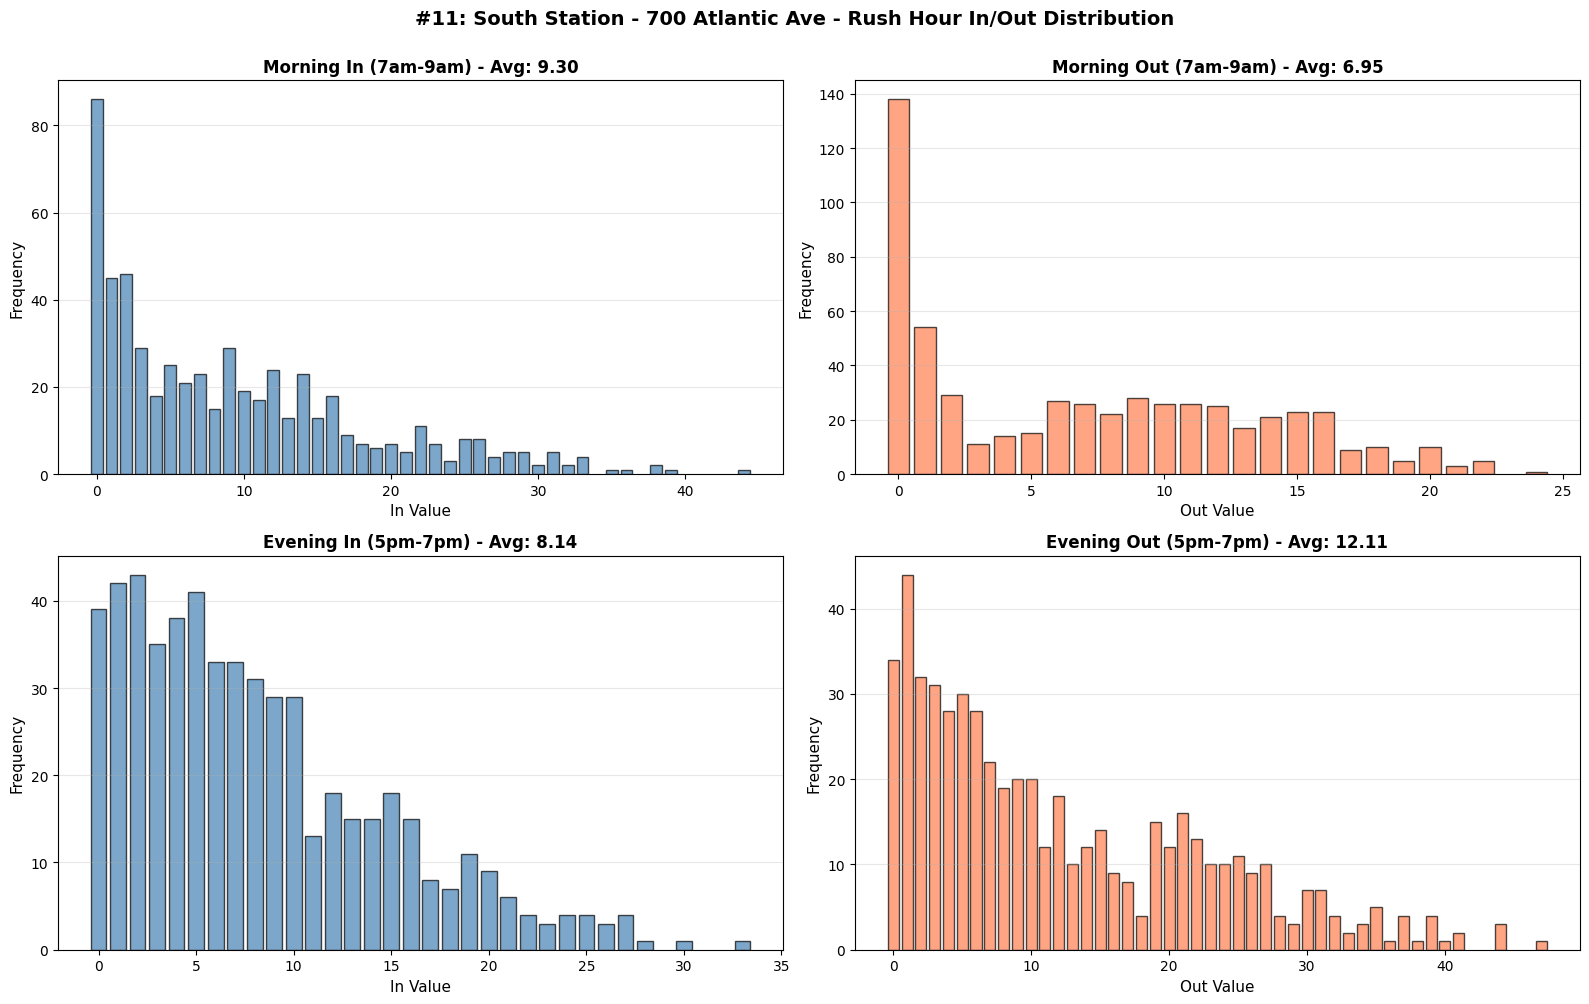

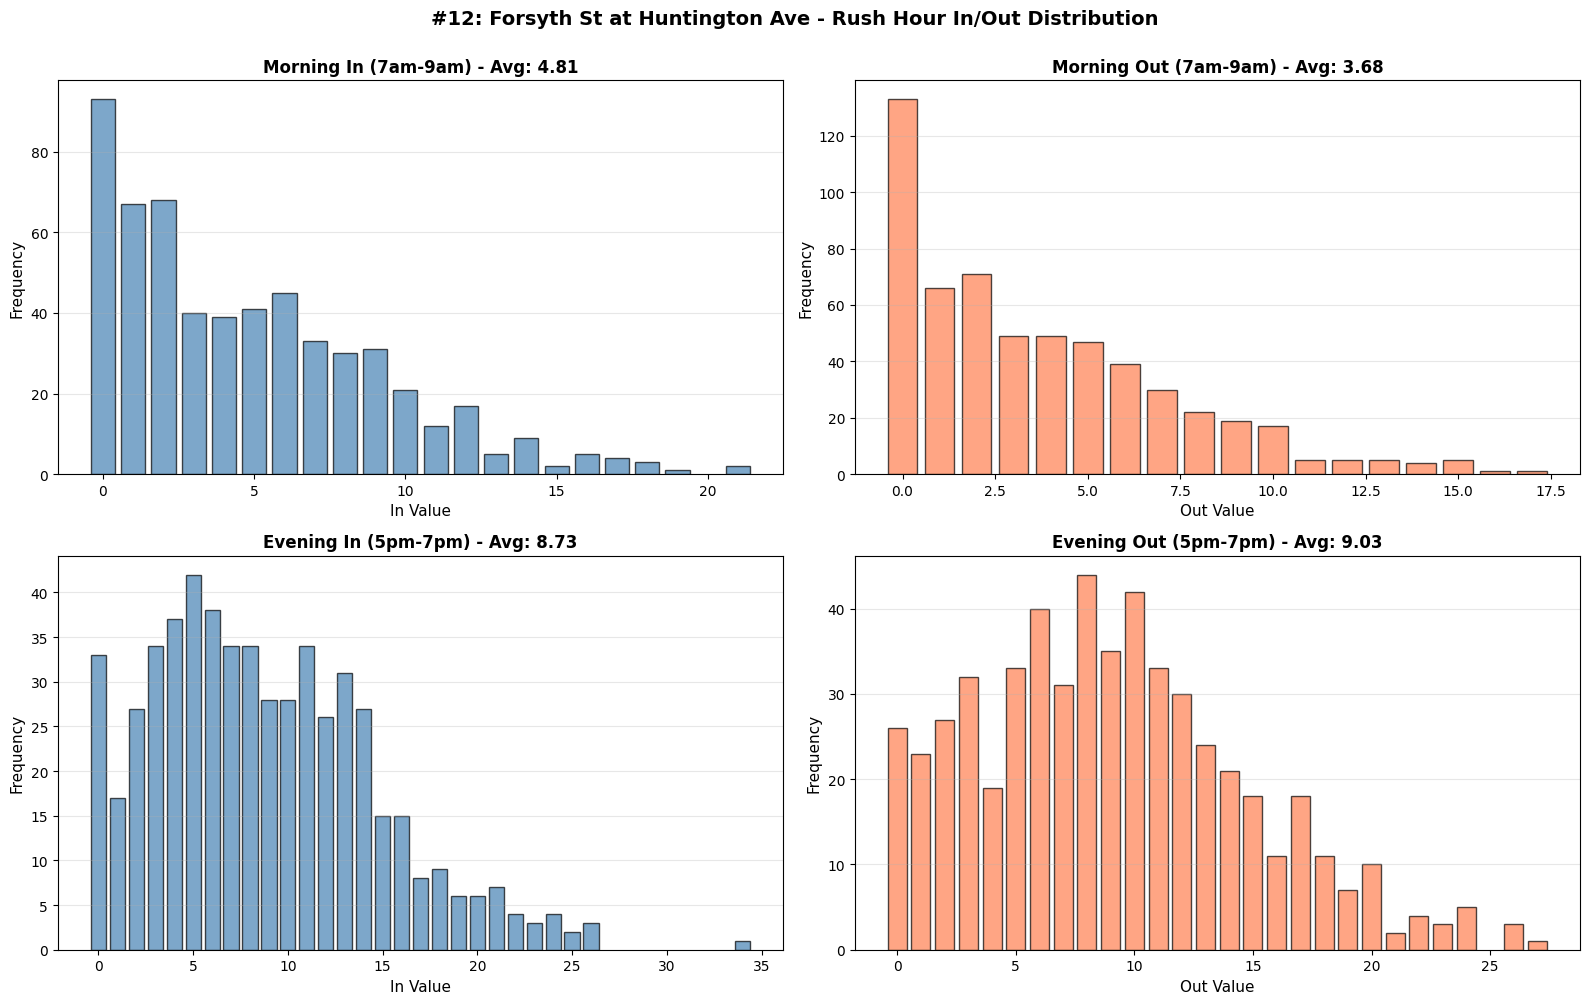

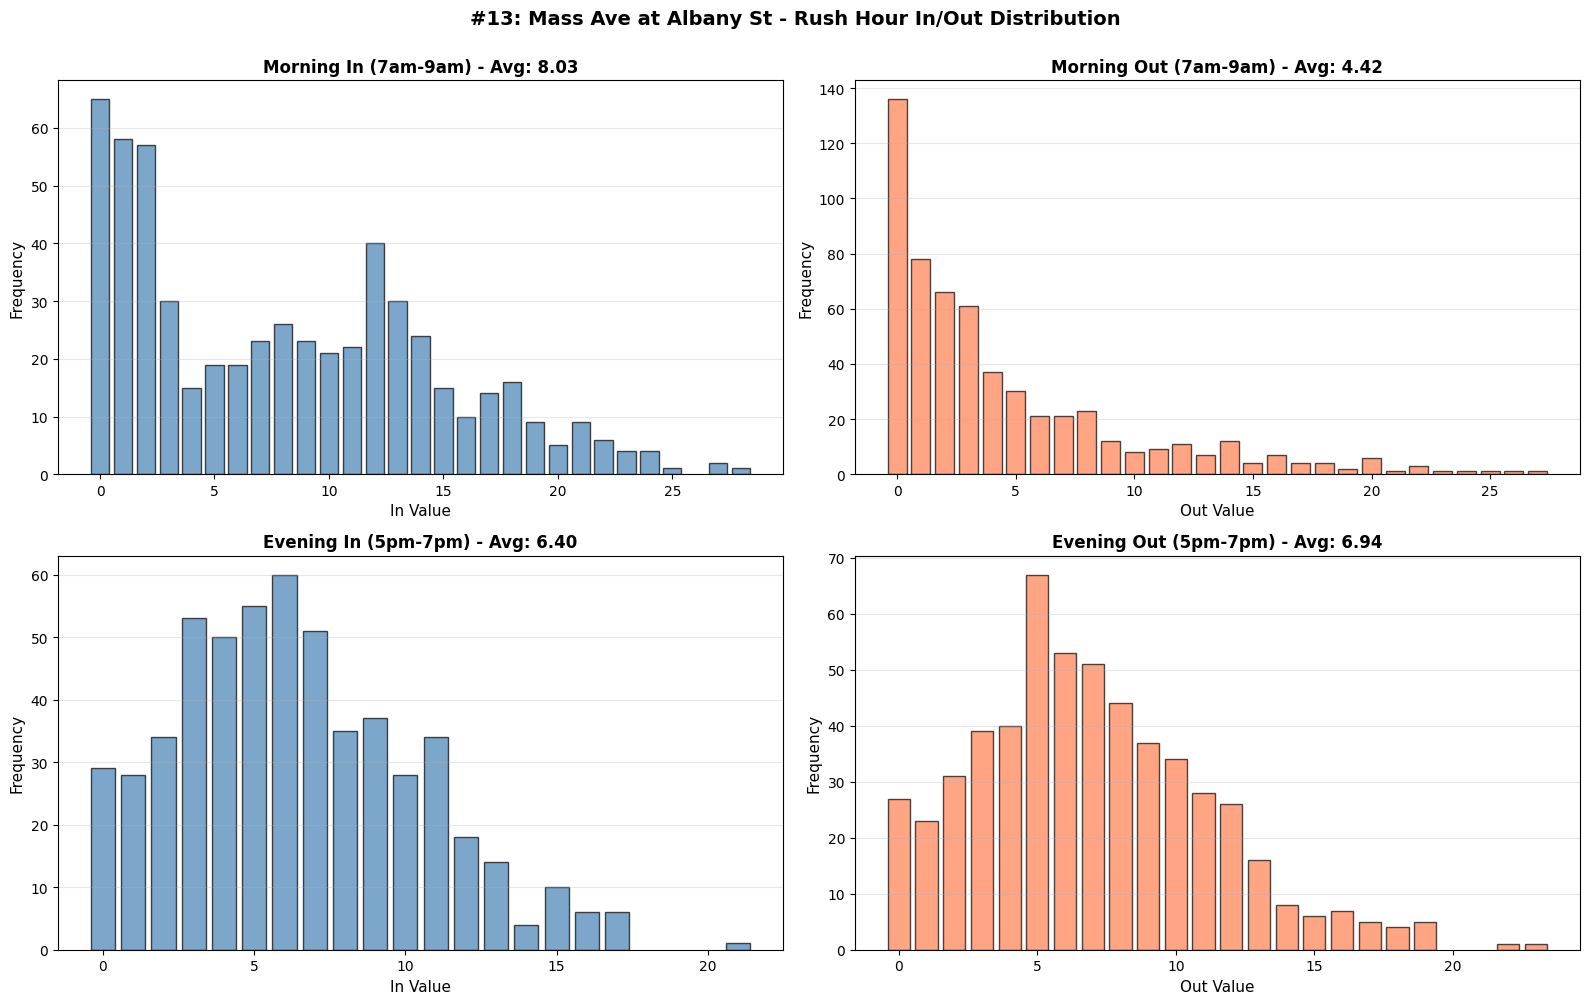

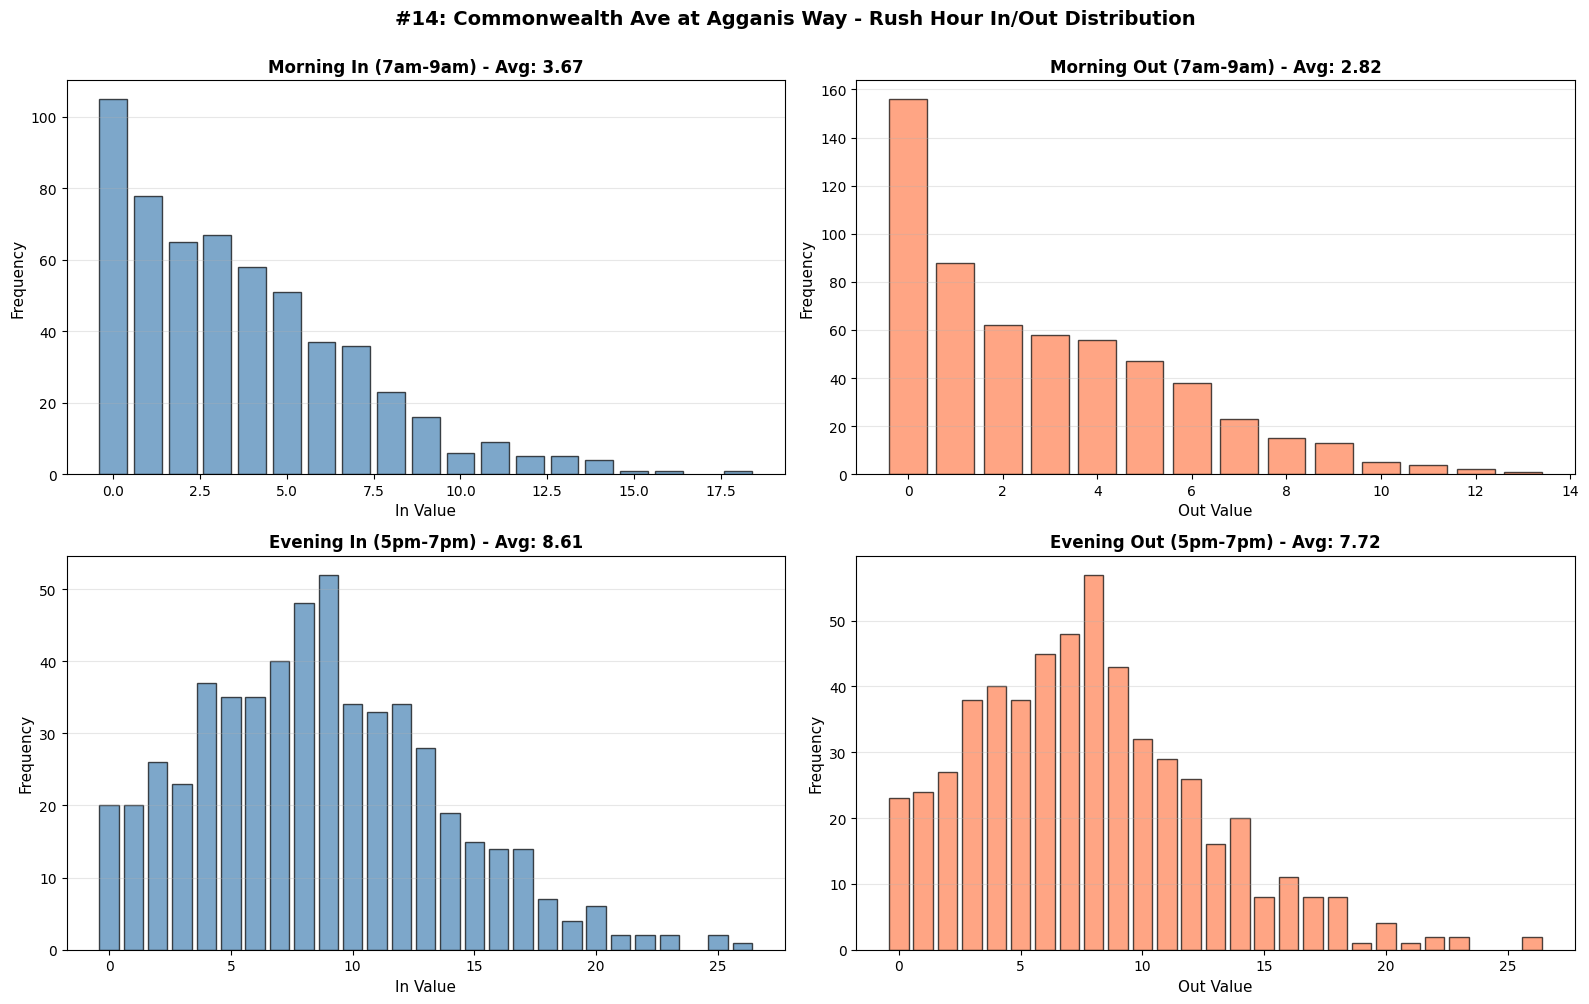

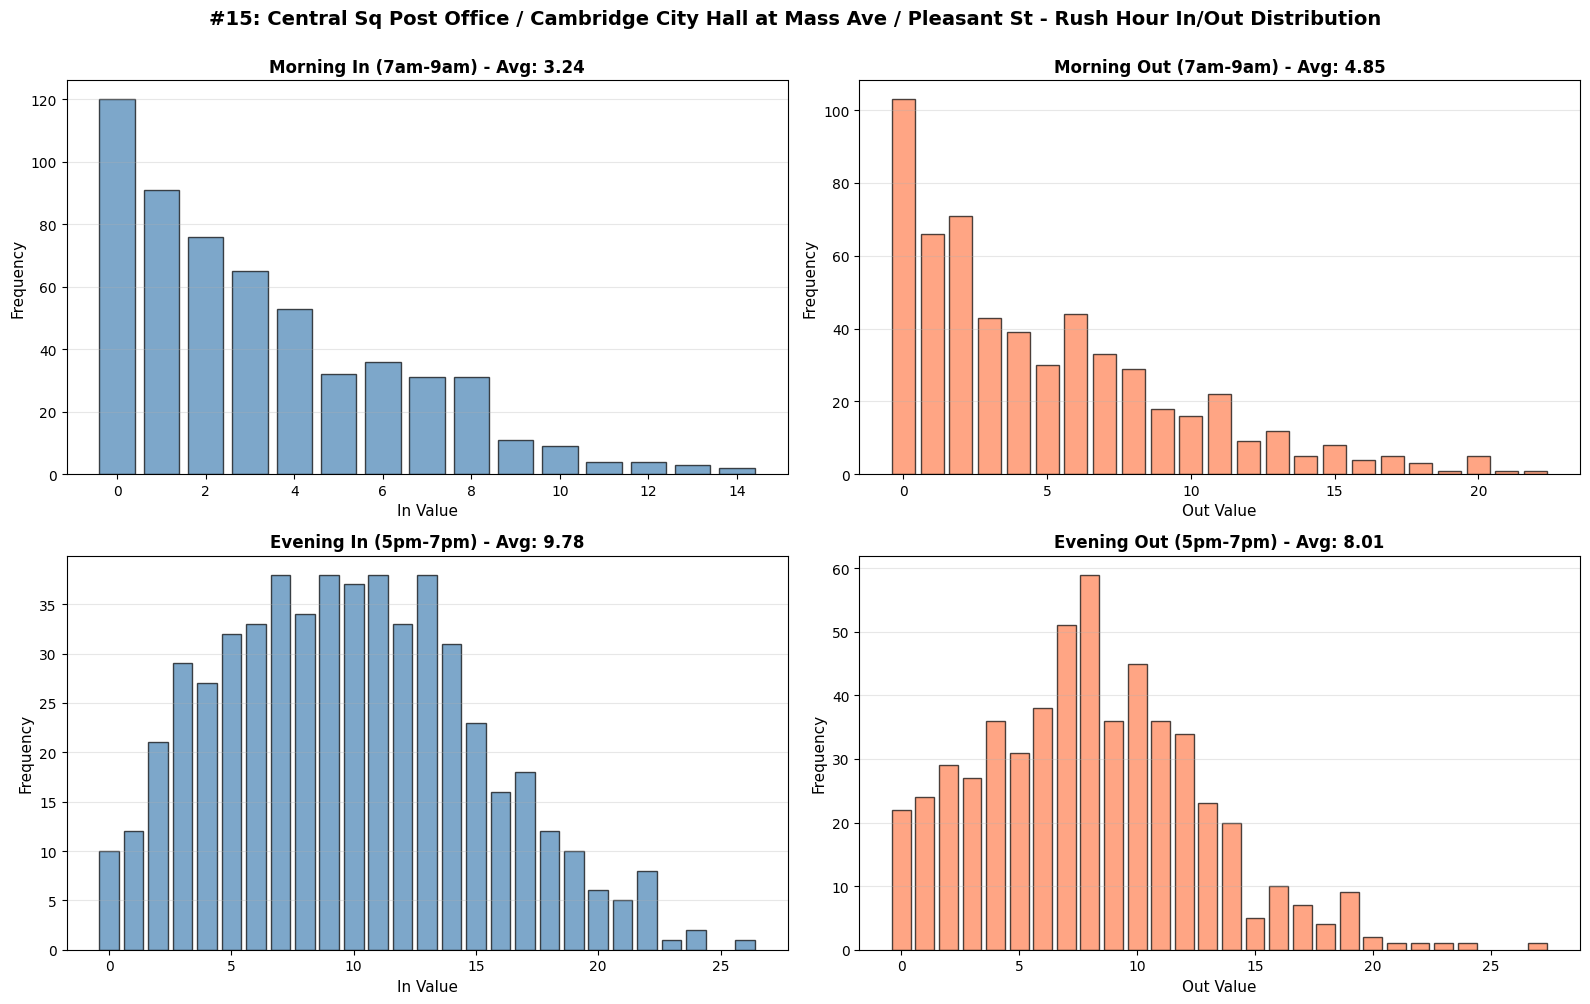

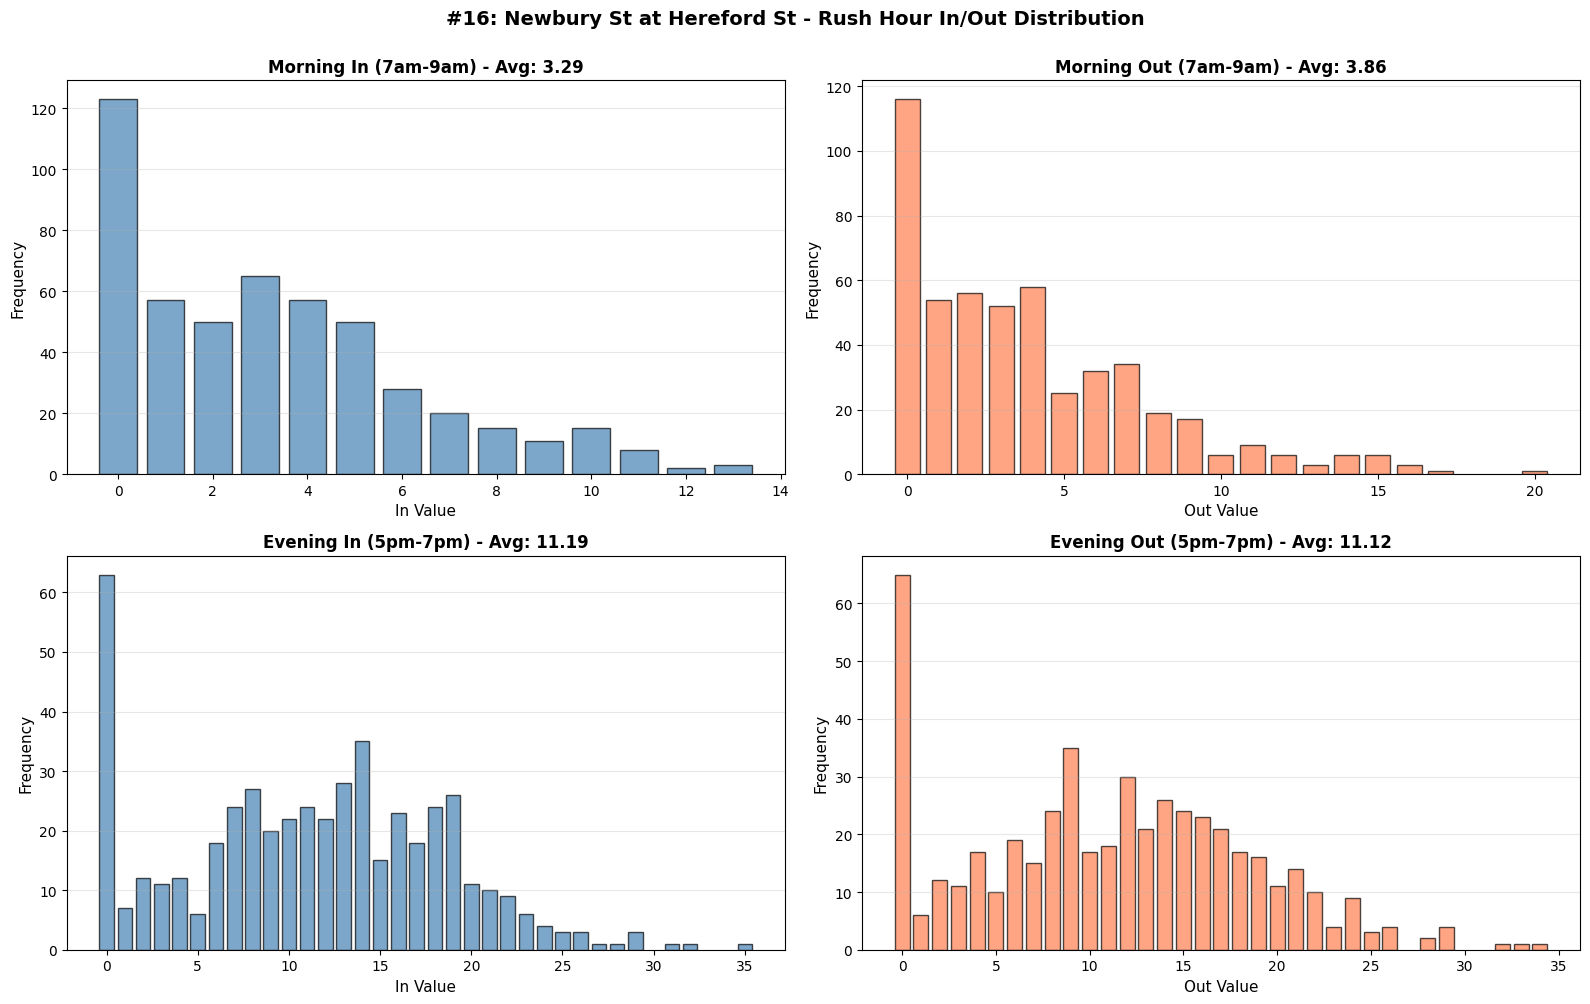

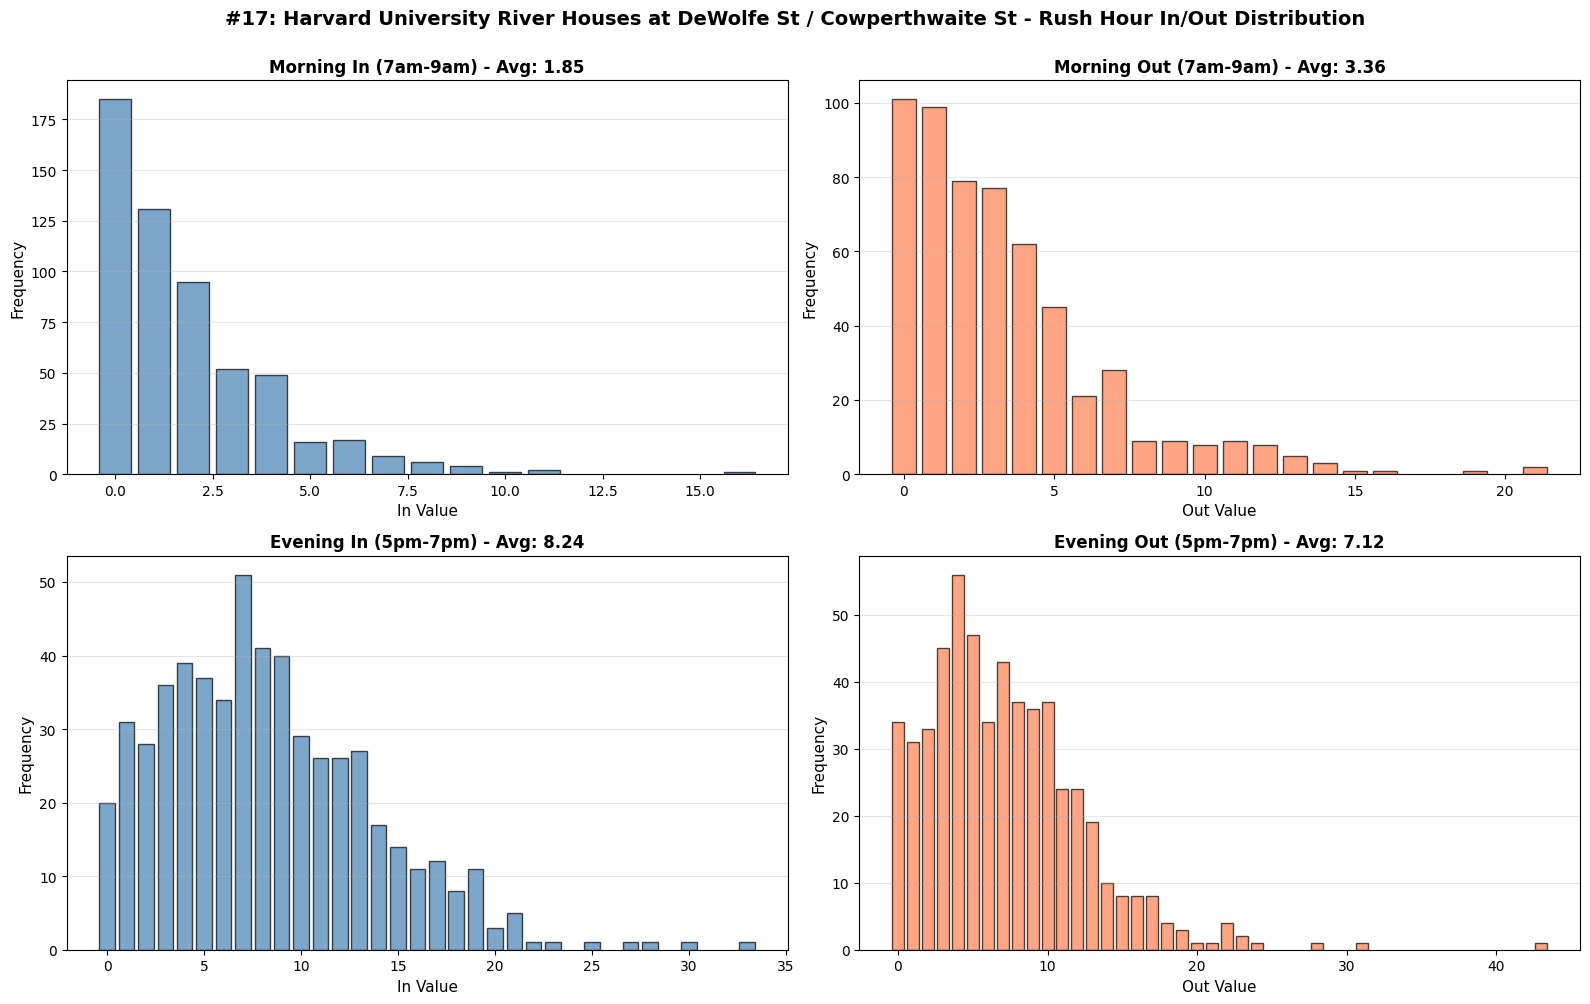

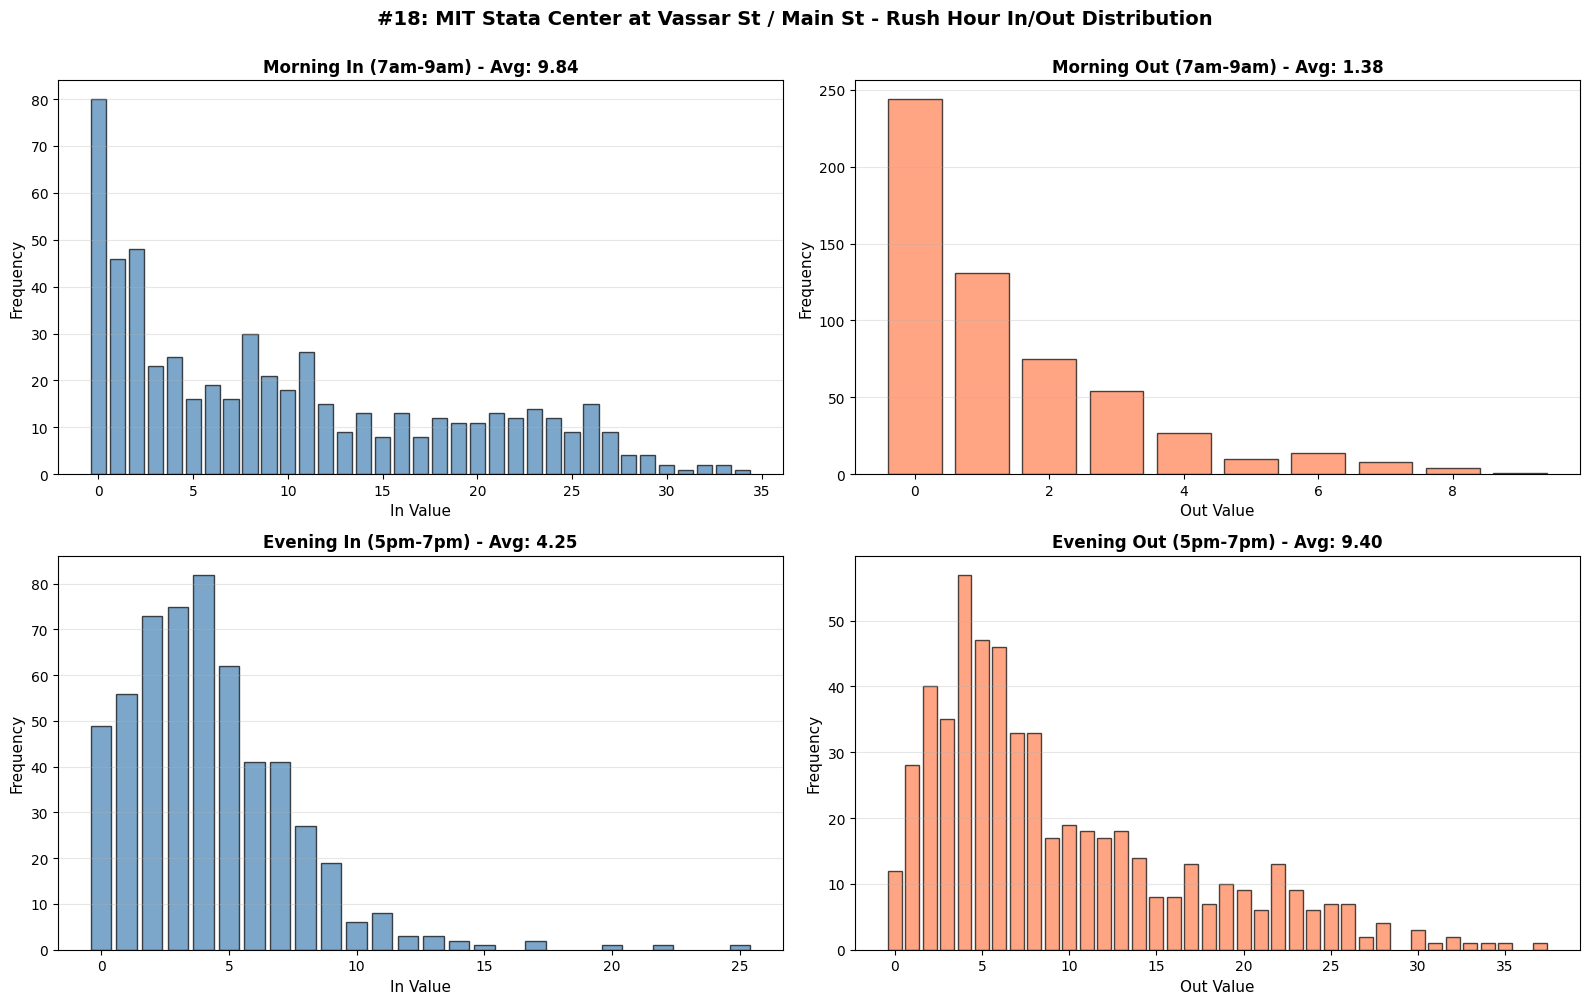

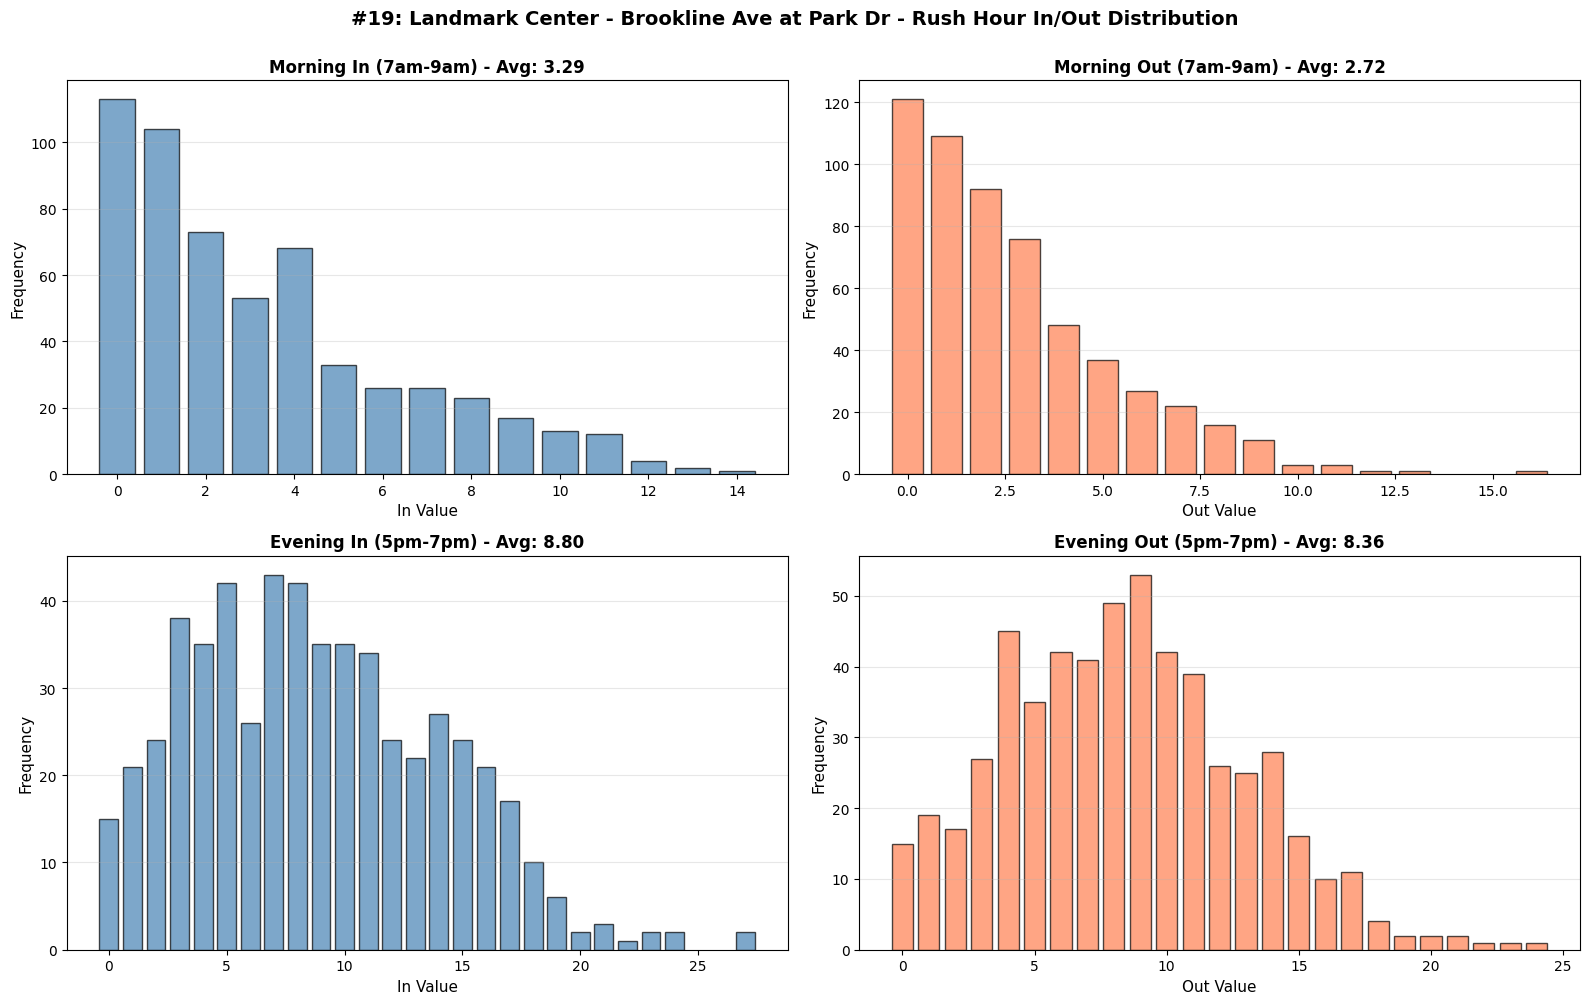

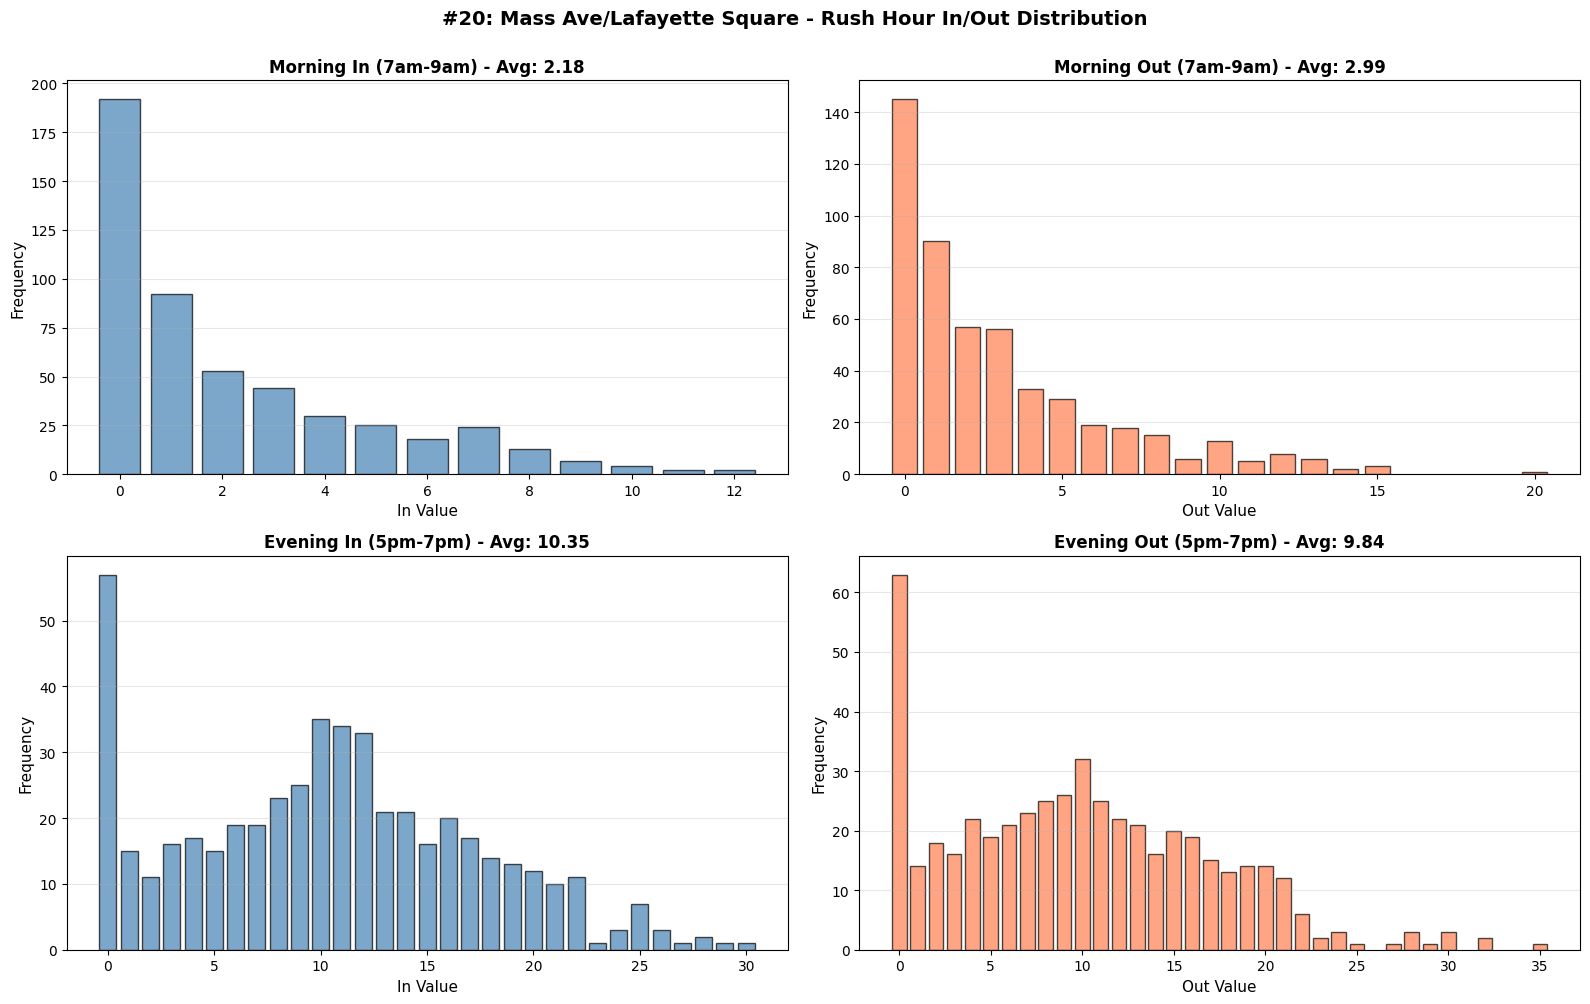

In [128]:
# Extract hour from timestart
df_top_20['hour'] = df_top_20['timestart'].dt.hour

# Define time intervals
morning_rush = (df_top_20['hour'] >= 7) & (df_top_20['hour'] < 9)
evening_rush = (df_top_20['hour'] >= 17) & (df_top_20['hour'] < 19)

# Filter data for each time interval
df_morning = df_top_20[morning_rush].copy()
df_evening = df_top_20[evening_rush].copy()

# Plot in and out distributions for each station during both time periods
for idx, station_name in enumerate(top_20_station_names, 1):
    # Filter data for this station
    morning_data = df_morning[df_morning['station_name'] == station_name]
    evening_data = df_evening[df_evening['station_name'] == station_name]
    
    # Calculate distributions for morning
    morning_in_dist = morning_data['in'].value_counts().sort_index()
    morning_out_dist = morning_data['out'].value_counts().sort_index()
    
    # Calculate distributions for evening
    evening_in_dist = evening_data['in'].value_counts().sort_index()
    evening_out_dist = evening_data['out'].value_counts().sort_index()
    
    # Get average values for titles
    avg_morning_in = morning_data['in'].mean()
    avg_morning_out = morning_data['out'].mean()
    avg_evening_in = evening_data['in'].mean()
    avg_evening_out = evening_data['out'].mean()
    
    # Create figure with 4 subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot morning rush In (7am-9am)
    axes[0, 0].bar(morning_in_dist.index, morning_in_dist.values, 
                   color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('In Value', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].set_title(f'Morning In (7am-9am) - Avg: {avg_morning_in:.2f}', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot morning rush Out (7am-9am)
    axes[0, 1].bar(morning_out_dist.index, morning_out_dist.values, 
                   color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Out Value', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title(f'Morning Out (7am-9am) - Avg: {avg_morning_out:.2f}', 
                         fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot evening rush In (5pm-7pm)
    axes[1, 0].bar(evening_in_dist.index, evening_in_dist.values, 
                   color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('In Value', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title(f'Evening In (5pm-7pm) - Avg: {avg_evening_in:.2f}', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot evening rush Out (5pm-7pm)
    axes[1, 1].bar(evening_out_dist.index, evening_out_dist.values, 
                   color='coral', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Out Value', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title(f'Evening Out (5pm-7pm) - Avg: {avg_evening_out:.2f}', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Overall title
    fig.suptitle(f'#{idx}: {station_name} - Rush Hour In/Out Distribution', 
                 fontsize=14, fontweight='bold', y=1.00)
    
    plt.tight_layout()
    plt.show()


## (fuck it) ZINB Regression

Load feature datasets

In [129]:
rapid_transit_stations = pd.read_csv("./mbta_stations/Rapid_Transit_Stops.csv")
rapid_transit_stations = rapid_transit_stations[["stop_name", "stop_lat", "stop_lon", "stop_address"]]

commuter_rail_stations = pd.read_csv("./mbta_stations/Commuter_Rail_Stops.csv")
commuter_rail_stations = commuter_rail_stations[["stop_name", "stop_lat", "stop_lon", "stop_address"]]

subway_stations = pd.concat([rapid_transit_stations, commuter_rail_stations], ignore_index=True)

bus_stations = pd.read_csv("./mbta_stations/Bus_Stops.csv")
bus_stations = bus_stations[["stop_name", "stop_lat", "stop_lon", "stop_address"]]

colleges = pd.read_csv("./mbta_stations/Universities.csv")
colleges = colleges[["NAME", "LAT", "LON", "STREET", "CITY", "STATE", "ZIP", "NMCNTY"]]

target_counties = ["Suffolk County", "Middlesex County", "Essex County", "Norfolk County", "Plymouth County"]
colleges = colleges[colleges["NMCNTY"].isin(target_counties)]

colleges["Address"] = colleges["STREET"] + ", " + colleges["CITY"]

colleges = colleges.rename(columns={
    "NAME": "Name",
    "LAT": "Latitude", 
    "LON": "Longitude"
})

colleges = colleges[["Name", "Latitude", "Longitude", "Address"]]

weather_files = ['202304-weather.csv', '202305-weather.csv', '202306-weather.csv', '202307-weather.csv', '202308-weather.csv', '202309-weather.csv', '202310-weather.csv', '202311-weather.csv', '202312-weather.csv']
weather_data = pd.DataFrame()
for weather_file in weather_files:
    month_data = pd.read_csv(weather_dir / weather_file, skipinitialspace=True)
    weather_data = pd.concat([weather_data, month_data], ignore_index=True)

Feature engineering helper functions

In [130]:
def extract_top_20_busiest_stations(df: pd.DataFrame) -> pd.DataFrame:
    station_activity = df.groupby('station_id').agg({
        'in': 'sum',
        'out': 'sum',
        'station_name': 'first',
        'latitude': 'first',
        'longitude': 'first'
    }).reset_index()

    station_activity['total_activity'] = station_activity['in'] + station_activity['out']

    top_20_stations = station_activity.nlargest(20, 'total_activity').reset_index(drop=True)
    
    return top_20_stations

def extract_bluebike_station_lat_long(df: pd.DataFrame ) -> list:
    stations = df[["station_id", "station_name", "latitude", "longitude"]].drop_duplicates("station_id")
    stations = stations.dropna(subset=["latitude", "longitude"])
    
    bluebike_station_lat_long = []
    for _, row in stations.iterrows():
        station_info = {
            "station_id": row["station_id"],
            "name": row["station_name"],
            "lat": row["latitude"],
            "lon": row["longitude"]
        }
        bluebike_station_lat_long.append(station_info)
    
    return bluebike_station_lat_long

def calculate_distance(lat1, lon1, lat2, lon2) -> float:
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) using Haversine formula
    Returns distance in meters
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    # Return distance in meters
    return c * r * 1000


def find_closest_subway(bluebike_station_lat_long: list) -> pd.DataFrame:
    closest_mbta_results = []

    for bluebike_station in bluebike_station_lat_long:
        bluebike_lat = bluebike_station['lat']
        bluebike_lon = bluebike_station['lon']
        bluebike_name = bluebike_station['name']
        bluebike_id = bluebike_station['station_id']
        
        min_distance = float('inf')
        closest_mbta = None
        
        # Calculate distance to each MBTA station
        for _, mbta_row in subway_stations.iterrows():
            mbta_lat = mbta_row['stop_lat']
            mbta_lon = mbta_row['stop_lon']
            
            # Skip if coordinates are missing
            if pd.isna(mbta_lat) or pd.isna(mbta_lon):
                continue
                
            distance = calculate_distance(bluebike_lat, bluebike_lon, mbta_lat, mbta_lon)
            
            if distance < min_distance:
                min_distance = distance
                closest_mbta = {
                    'name': mbta_row['stop_name'],
                    'address': mbta_row['stop_address'],
                    'lat': mbta_lat,
                    'lon': mbta_lon,
                    'distance_m': distance
                }
        
        # Add result to list
        if closest_mbta:
            result = {
                'station_name': bluebike_name,
                'station_id': bluebike_id,
                'station_latitude': bluebike_lat,
                'station_longitude': bluebike_lon,
                'closest_subway_name': closest_mbta['name'],
                'closest_subway_address': closest_mbta['address'],
                'closest_subway_latitude': closest_mbta['lat'],
                'closest_subway_longitude': closest_mbta['lon'],
                'subway_distance_m': round(closest_mbta['distance_m'], 3)
            }
            closest_mbta_results.append(result)
    
    return pd.DataFrame(closest_mbta_results)
            
            
def find_closet_bus_station(bluebike_station_lat_long: list) -> pd.DataFrame:
    closest_bus_results = []

    for bluebike_station in bluebike_station_lat_long:
        bluebike_lat = bluebike_station['lat']
        bluebike_lon = bluebike_station['lon']
        bluebike_name = bluebike_station['name']
        bluebike_id = bluebike_station['station_id']
        
        min_distance = float('inf')
        closest_bus = None
        
        # Calculate distance to each bus station
        for _, bus_row in bus_stations.iterrows():
            bus_lat = bus_row['stop_lat']
            bus_lon = bus_row['stop_lon']
            
            # Skip if coordinates are missing
            if pd.isna(bus_lat) or pd.isna(bus_lon):
                continue
                
            distance = calculate_distance(bluebike_lat, bluebike_lon, bus_lat, bus_lon)
            
            if distance < min_distance:
                min_distance = distance
                closest_bus = {
                    'name': bus_row['stop_name'],
                    'address': bus_row['stop_address'],
                    'lat': bus_lat,
                    'lon': bus_lon,
                    'distance_m': distance
                }
        
        # Add result to list
        if closest_bus:
            result = {
                'station_name': bluebike_name,
                'station_id': bluebike_id,
                'station_latitude': bluebike_lat,
                'station_longitude': bluebike_lon,
                'closest_bus_name': closest_bus['name'],
                'closest_bus_address': closest_bus['address'],
                'closest_bus_latitude': closest_bus['lat'],
                'closest_bus_longitude': closest_bus['lon'],
                'bus_distance_m': round(closest_bus['distance_m'], 3)
            }
            closest_bus_results.append(result)
            
    return pd.DataFrame(closest_bus_results)

def find_nearest_university(bluebike_station_lat_long: list) -> pd.DataFrame:
    closest_university_results = []

    for bluebike_station in bluebike_station_lat_long:
        bluebike_lat = bluebike_station['lat']
        bluebike_lon = bluebike_station['lon']
        bluebike_name = bluebike_station['name']
        bluebike_id = bluebike_station['station_id']
        
        min_distance = float('inf')
        closest_university = None
        
        # Calculate distance to each university
        for _, uni_row in colleges.iterrows():
            uni_lat = uni_row['Latitude']
            uni_lon = uni_row['Longitude']
            
            # Skip if coordinates are missing
            if pd.isna(uni_lat) or pd.isna(uni_lon):
                continue
                
            distance = calculate_distance(bluebike_lat, bluebike_lon, uni_lat, uni_lon)
            
            if distance < min_distance:
                min_distance = distance
                closest_university = {
                    'name': uni_row['Name'],
                    'address': uni_row['Address'],
                    'lat': uni_lat,
                    'lon': uni_lon,
                    'distance_m': distance
                }
        
        # Add result to list
        if closest_university:
            result = {
                'station_name': bluebike_name,
                'station_id': bluebike_id,
                'station_latitude': bluebike_lat,
                'station_longitude': bluebike_lon,
                'closest_university_name': closest_university['name'],
                'closest_university_address': closest_university['address'],
                'closest_university_latitude': closest_university['lat'],
                'closest_university_longitude': closest_university['lon'],
                'university_distance_m': round(closest_university['distance_m'], 3)
            }
            closest_university_results.append(result)
    
    return pd.DataFrame(closest_university_results)

def count_nearby_subway_stations(bluebike_station_lat_long: list, radius_m: float = 250) -> pd.DataFrame:
    """
    Count the number of MBTA subway/commuter rail stations within a specified radius
    of each BlueBike station.
    """
    count_results = []
    
    for bluebike_station in bluebike_station_lat_long:
        bluebike_lat = bluebike_station['lat']
        bluebike_lon = bluebike_station['lon']
        bluebike_id = bluebike_station['station_id']
        
        count = 0
        
        # Count MBTA stations within radius
        for _, mbta_row in subway_stations.iterrows():
            mbta_lat = mbta_row['stop_lat']
            mbta_lon = mbta_row['stop_lon']
            
            # Skip if coordinates are missing
            if pd.isna(mbta_lat) or pd.isna(mbta_lon):
                continue
                
            distance = calculate_distance(bluebike_lat, bluebike_lon, mbta_lat, mbta_lon)
            
            if distance <= radius_m:
                count += 1
        
        result = {
            'station_id': bluebike_id,
            'mbta_stops_250m': count
        }
        count_results.append(result)
    
    return pd.DataFrame(count_results)

def count_nearby_bus_stops(bluebike_station_lat_long: list, radius_m: float = 250) -> pd.DataFrame:
    """
    Count the number of bus stops within a specified radius of each BlueBike station.
    """
    count_results = []
    
    for bluebike_station in bluebike_station_lat_long:
        bluebike_lat = bluebike_station['lat']
        bluebike_lon = bluebike_station['lon']
        bluebike_id = bluebike_station['station_id']
        
        count = 0
        
        # Count bus stops within radius
        for _, bus_row in bus_stations.iterrows():
            bus_lat = bus_row['stop_lat']
            bus_lon = bus_row['stop_lon']
            
            # Skip if coordinates are missing
            if pd.isna(bus_lat) or pd.isna(bus_lon):
                continue
                
            distance = calculate_distance(bluebike_lat, bluebike_lon, bus_lat, bus_lon)
            
            if distance <= radius_m:
                count += 1
        
        result = {
            'station_id': bluebike_id,
            'bus_stops_250m': count
        }
        count_results.append(result)
    
    return pd.DataFrame(count_results)

def transform_weather_data(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['precipitation'] = df['precipitation'].replace('T', '0.0')
    df['precipitation'] = pd.to_numeric(df['precipitation'], errors='coerce')
    return df

Feature engineering execution

In [131]:
# Step 1: Extract top 20 busiest stations
top_20_stations = extract_top_20_busiest_stations(df_transformed)
print(f"Extracted {len(top_20_stations)} busiest stations")
print()

# Step 2: Get BlueBike station coordinates for top 20
top_20_station_ids = top_20_stations['station_id'].tolist()
top_20_coords = extract_bluebike_station_lat_long(df_transformed)
top_20_coords = [s for s in top_20_coords if s['station_id'] in top_20_station_ids]
print(f"Got coordinates for {len(top_20_coords)} stations")
print()

# Step 3: Find closest features using helper functions
print("Finding closest universities...")
nearest_universities = find_nearest_university(top_20_coords)
print(f"Found {len(nearest_universities)} university matches")
print()

print("Finding closest subway/commuter rail stations...")
nearest_subway = find_closest_subway(top_20_coords)
print(f"Found {len(nearest_subway)} subway matches")
print()

print("Finding closest bus stations...")
nearest_bus = find_closet_bus_station(top_20_coords)
print(f"Found {len(nearest_bus)} bus matches")
print()

print("Counting nearby MBTA stops (within 250m)...")
mbta_counts = count_nearby_subway_stations(top_20_coords, radius_m=250)
print(f"Computed counts for {len(mbta_counts)} stations")
print()

print("Counting nearby bus stops (within 250m)...")
bus_counts = count_nearby_bus_stops(top_20_coords, radius_m=250)
print(f"Computed counts for {len(bus_counts)} stations")
print()

print("Transforming weather data...")
weather_features = transform_weather_data(weather_data)
print(f"Transformed {len(weather_features)} lines")
print()

# Step 4: Merge the feature DataFrames
# Start with universities
features_df = nearest_universities[['station_id', 'closest_university_name', 
                                     'closest_university_address', 'closest_university_latitude',
                                     'closest_university_longitude', 'university_distance_m']]

# Merge subway data
subway_features = nearest_subway[['station_id', 'closest_subway_name',
                                   'closest_subway_address', 'closest_subway_latitude',
                                   'closest_subway_longitude', 'subway_distance_m']]
features_df = features_df.merge(subway_features, on='station_id', how='outer')

# Merge bus data
bus_features = nearest_bus[['station_id', 'closest_bus_name',
                             'closest_bus_address', 'closest_bus_latitude',
                             'closest_bus_longitude', 'bus_distance_m']]
features_df = features_df.merge(bus_features, on='station_id', how='outer')

# Merge MBTA and bus counts
features_df = features_df.merge(mbta_counts, on='station_id', how='outer')
features_df = features_df.merge(bus_counts, on='station_id', how='outer')

# Step 5: Filter df_transformed to top 20 stations and join features
df_top_20_enriched = df_transformed[df_transformed['station_id'].isin(top_20_station_ids)].copy()
df_top_20_enriched = df_top_20_enriched.merge(features_df, on='station_id', how='left')

# Step 6: Extract date from timestart and merge weather data
df_top_20_enriched['date'] = df_top_20_enriched['timestart'].dt.date
df_top_20_enriched['date'] = pd.to_datetime(df_top_20_enriched['date'])
df_top_20_enriched = df_top_20_enriched.merge(weather_features, on='date', how='left')


print(f"Final enriched dataframe shape: {df_top_20_enriched.shape}")
print(f"\nColumns in enriched dataframe:")
print(df_top_20_enriched.columns.tolist())
print()

print("Sample of enriched data:")
print(df_top_20_enriched.head(20))

Extracted 20 busiest stations

Got coordinates for 20 stations

Finding closest universities...
Found 20 university matches

Finding closest subway/commuter rail stations...
Found 20 subway matches

Finding closest bus stations...
Found 20 bus matches

Counting nearby MBTA stops (within 250m)...
Computed counts for 20 stations

Counting nearby bus stops (within 250m)...
Computed counts for 20 stations

Transforming weather data...
Transformed 275 lines

Final enriched dataframe shape: (132404, 45)

Columns in enriched dataframe:
['timestart', 'timeend', 'station_name', 'month', 'day_of_week', 'start_hour', 'end_hour', 'is_night', 'station_id', 'latitude', 'longitude', 'in', 'out', 'last_hour_in', 'last_hour_out', 'last_two_hour_in', 'last_two_hour_out', 'last_three_hour_in', 'last_three_hour_out', 'closest_university_name', 'closest_university_address', 'closest_university_latitude', 'closest_university_longitude', 'university_distance_m', 'closest_subway_name', 'closest_subway_address

ZINB Regression Training

In [132]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [133]:
# Prepare features for ZINB regression
# Select numerical features from df_top_20_enriched
feature_cols = [
    'month', 'day_of_week', 
    'start_hour', 'end_hour',
    'university_distance_m',
    'subway_distance_m',
    'bus_distance_m',
    'mbta_stops_250m',
    'bus_stops_250m',
    'last_hour_in',
    'last_hour_out',
    'last_two_hour_in',
    'last_two_hour_out',
    'last_three_hour_in',
    'last_three_hour_out',
    'is_night',
    'avg_temp',
    'precipitation'
]

# Define negative binomial features
nb_features = [
    'month',
    'start_hour',
    'end_hour',
    'bus_distance_m',
    'last_three_hour_in',
    'last_three_hour_out',
]

# Define inflation features
infl_features = ['is_night', 'precipitation', 'avg_temp']

# Convert all columns to numeric, coercing errors to NaN
for col in feature_cols:
    df_top_20_enriched[col] = pd.to_numeric(df_top_20_enriched[col], errors='coerce')

# Drop rows with missing values only in feature columns
df_top_20_enriched = df_top_20_enriched.dropna(subset=feature_cols).reset_index(drop=True)

# Prepare data - ensure all numeric types and handle missing values
X = df_top_20_enriched[feature_cols].copy().values
y_out = df_top_20_enriched['out'].values
y_in = df_top_20_enriched['in'].values

# Split into train and test sets - use the SAME indices for both targets
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X[train_idx])
X_test = scaler.transform(X[test_idx])

y_out_train = y_out[train_idx]
y_out_test = y_out[test_idx]
y_in_train = y_in[train_idx]
y_in_test = y_in[test_idx]

# Add constant term for intercept
X_train_const = sm.add_constant(X_train[:, [feature_cols.index(f) for f in nb_features]])
X_train_infl = sm.add_constant(X_train[:, [feature_cols.index(f) for f in infl_features]])
X_test_const = sm.add_constant(X_test[:, [feature_cols.index(f) for f in nb_features]])
X_test_infl = sm.add_constant(X_test[:, [feature_cols.index(f) for f in infl_features]])

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Feature columns: {feature_cols}")
print(f"Negative binomial features: {nb_features}")
print(f"Inflation features: {infl_features}")
print(f"Features shape (with constant): {X_train_const.shape}")
print(f"X_train_const dtype: {X_train_const.dtype}")
print(f"y_out_train dtype: {y_out_train.dtype}")
print()

# ============================================================================
# MODEL 1: ZINB for OUT counts
# ============================================================================

print("="*70)
print("MODEL 1: Fitting ZINB for OUT Counts")
print("="*70)
print()

# Fit the model - both count and inflation models use the same features
zinb_out_model = ZeroInflatedNegativeBinomialP(
    endog=y_out_train,
    exog=X_train_const,          # Features for count model (predicts μ)
    exog_infl=X_train_infl,     # Features for inflation model (predicts π)
    p=2                           # NB-P parameterization (p=2 is standard NB2)
)

# Fit with maximum likelihood
zinb_out_results = zinb_out_model.fit(method='bfgs', maxiter=1000, disp=True)

print()
print("="*70)
print("OUT Model Summary")
print("="*70)
print(zinb_out_results.summary())

# ============================================================================
# MODEL 2: ZINB for IN counts
# ============================================================================

print()
print("="*70)
print("MODEL 2: Fitting ZINB for IN Counts")
print("="*70)
print()

# Fit the model - both count and inflation models use the same features
zinb_in_model = ZeroInflatedNegativeBinomialP(
    endog=y_in_train,
    exog=X_train_const,          # Features for count model (predicts μ)
    exog_infl=X_train_infl,     # Features for inflation model (predicts π)
    p=2                           # NB-P parameterization (p=2 is standard NB2)
)

# Fit with maximum likelihood
zinb_in_results = zinb_in_model.fit(method='bfgs', maxiter=1000, disp=True)

print()
print("="*70)
print("IN Model Summary")
print("="*70)
print(zinb_in_results.summary())


Training set size: 105750
Test set size: 26438
Feature columns: ['month', 'day_of_week', 'start_hour', 'end_hour', 'university_distance_m', 'subway_distance_m', 'bus_distance_m', 'mbta_stops_250m', 'bus_stops_250m', 'last_hour_in', 'last_hour_out', 'last_two_hour_in', 'last_two_hour_out', 'last_three_hour_in', 'last_three_hour_out', 'is_night', 'avg_temp', 'precipitation']
Negative binomial features: ['month', 'start_hour', 'end_hour', 'bus_distance_m', 'last_three_hour_in', 'last_three_hour_out']
Inflation features: ['is_night', 'precipitation', 'avg_temp']
Features shape (with constant): (105750, 7)
X_train_const dtype: float64
y_out_train dtype: int64

MODEL 1: Fitting ZINB for OUT Counts

Optimization terminated successfully.
         Current function value: 2.410908
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49

OUT Model Summary
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:   

Model Evaluation

In [134]:
# ============================================================================
# PREDICTIONS AND EVALUATION
# ============================================================================

print()
print("="*70)
print("Test Set Predictions - OUT Model")
print("="*70)
print()

# OUT predictions
# y_out_pred = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean')
# pi_out_pred = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='prob-zero')
# mu_out_pred = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean-main')

# Modified OUT predictions
y_out_pred_original = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean')
pi_out_pred = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='prob-zero')
mu_out_pred = zinb_out_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean-main')

# Apply rule: if pi > 0.5, set prediction to 0
y_out_pred = np.round(np.where(pi_out_pred > 0.5, 0, y_out_pred_original))

# Evaluate OUT predictions
mse_out = mean_squared_error(y_out_test, y_out_pred)
mae_out = mean_absolute_error(y_out_test, y_out_pred)
rmse_out = np.sqrt(mse_out)
r2_out = r2_score(y_out_test, y_out_pred)

alpha_idx = len(zinb_out_results.params) - 1
alpha = zinb_out_results.params[alpha_idx]

print(f"OUT Prediction Metrics:")
print(f"  RMSE: {rmse_out:.4f}")
print(f"  MAE: {mae_out:.4f}")
print(f"  MSE: {mse_out:.4f}")
print(f"  R²: {r2_out:.4f}")
print()

print(f"OUT Distribution Parameter Statistics:")
print(f"  Zero-inflation probability π:")
print(f"    Mean: {pi_out_pred.mean():.4f}")
print(f"    Std:  {pi_out_pred.std():.4f}")
print(f"  NB mean μ (from count model):")
print(f"    Mean: {mu_out_pred.mean():.4f}")
print(f"    Std:  {mu_out_pred.std():.4f}")
print(f"  Dispersion parameter α: {alpha:.4f}")
print()

print()
print("="*70)
print("Test Set Predictions - IN Model")
print("="*70)
print()

# IN predictions
# y_in_pred = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean')
# pi_in_pred = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='prob-zero')
# mu_in_pred = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean-main')

# Modified IN predictions
y_in_pred_original = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean')
pi_in_pred = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='prob-zero')
mu_in_pred = zinb_in_results.predict(exog=X_test_const, exog_infl=X_test_infl, which='mean-main')

# Apply rule: if pi > 0.5, set prediction to 0
y_in_pred = np.round(np.where(pi_in_pred > 0.5, 0, y_in_pred_original))

# Evaluate IN predictions
mse_in = mean_squared_error(y_in_test, y_in_pred)
mae_in = mean_absolute_error(y_in_test, y_in_pred)
rmse_in = np.sqrt(mse_in)
r2_in = r2_score(y_in_test, y_in_pred)

alpha_idx = len(zinb_out_results.params) - 1
alpha = zinb_out_results.params[alpha_idx]

print(f"IN Prediction Metrics:")
print(f"  RMSE: {rmse_in:.4f}")
print(f"  MAE: {mae_in:.4f}")
print(f"  MSE: {mse_in:.4f}")
print(f"  R²: {r2_in:.4f}")
print()

print(f"IN Distribution Parameter Statistics:")
print(f"  Zero-inflation probability π:")
print(f"    Mean: {pi_in_pred.mean():.4f}")
print(f"    Std:  {pi_in_pred.std():.4f}")
print(f"  NB mean μ (from count model):")
print(f"    Mean: {mu_in_pred.mean():.4f}")
print(f"    Std:  {mu_in_pred.std():.4f}")
print(f"  Dispersion parameter α: {alpha:.4f}")
print()

# ============================================================================
# FEATURE IMPORTANCE COMPARISON
# ============================================================================

print()
print("="*70)
print("Feature Importance Comparison")
print("="*70)
print()

# Recreate feature names (with const)
feature_names_with_const = ['const'] + nb_features

# OUT Count model coefficients
print("OUT Count Model Coefficients (predicting μ_out):")
count_params_out = zinb_out_results.params[:len(feature_names_with_const)]
count_pvalues_out = zinb_out_results.pvalues[:len(feature_names_with_const)]
for i, col in enumerate(feature_names_with_const):
    sig = "***" if count_pvalues_out[i] < 0.001 else "**" if count_pvalues_out[i] < 0.01 else "*" if count_pvalues_out[i] < 0.05 else ""
    print(f"  {col:30s}: {count_params_out[i]:10.4f}  (p={count_pvalues_out[i]:.4f}) {sig}")
print()

# IN Count model coefficients
print("IN Count Model Coefficients (predicting μ_in):")
count_params_in = zinb_in_results.params[:len(feature_names_with_const)]
count_pvalues_in = zinb_in_results.pvalues[:len(feature_names_with_const)]
for i, col in enumerate(feature_names_with_const):
    sig = "***" if count_pvalues_in[i] < 0.001 else "**" if count_pvalues_in[i] < 0.01 else "*" if count_pvalues_in[i] < 0.05 else ""
    print(f"  {col:30s}: {count_params_in[i]:10.4f}  (p={count_pvalues_in[i]:.4f}) {sig}")
print()


Test Set Predictions - OUT Model

OUT Prediction Metrics:
  RMSE: 5.2343
  MAE: 3.2862
  MSE: 27.3979
  R²: 0.1983

OUT Distribution Parameter Statistics:
  Zero-inflation probability π:
    Mean: 0.2574
    Std:  0.1968
  NB mean μ (from count model):
    Mean: 5.2905
    Std:  4.4997
  Dispersion parameter α: 0.7342


Test Set Predictions - IN Model

IN Prediction Metrics:
  RMSE: 5.0750
  MAE: 3.2928
  MSE: 25.7552
  R²: 0.2149

IN Distribution Parameter Statistics:
  Zero-inflation probability π:
    Mean: 0.2573
    Std:  0.2036
  NB mean μ (from count model):
    Mean: 5.2686
    Std:  3.8884
  Dispersion parameter α: 0.7342


Feature Importance Comparison

OUT Count Model Coefficients (predicting μ_out):
  const                         :   -10.5279  (p=0.7056) 
  month                         :     6.5262  (p=0.7158) 
  start_hour                    :     0.0483  (p=0.0016) **
  end_hour                      :    -0.1916  (p=0.0000) ***
  bus_distance_m                :     1.4

Visualizations

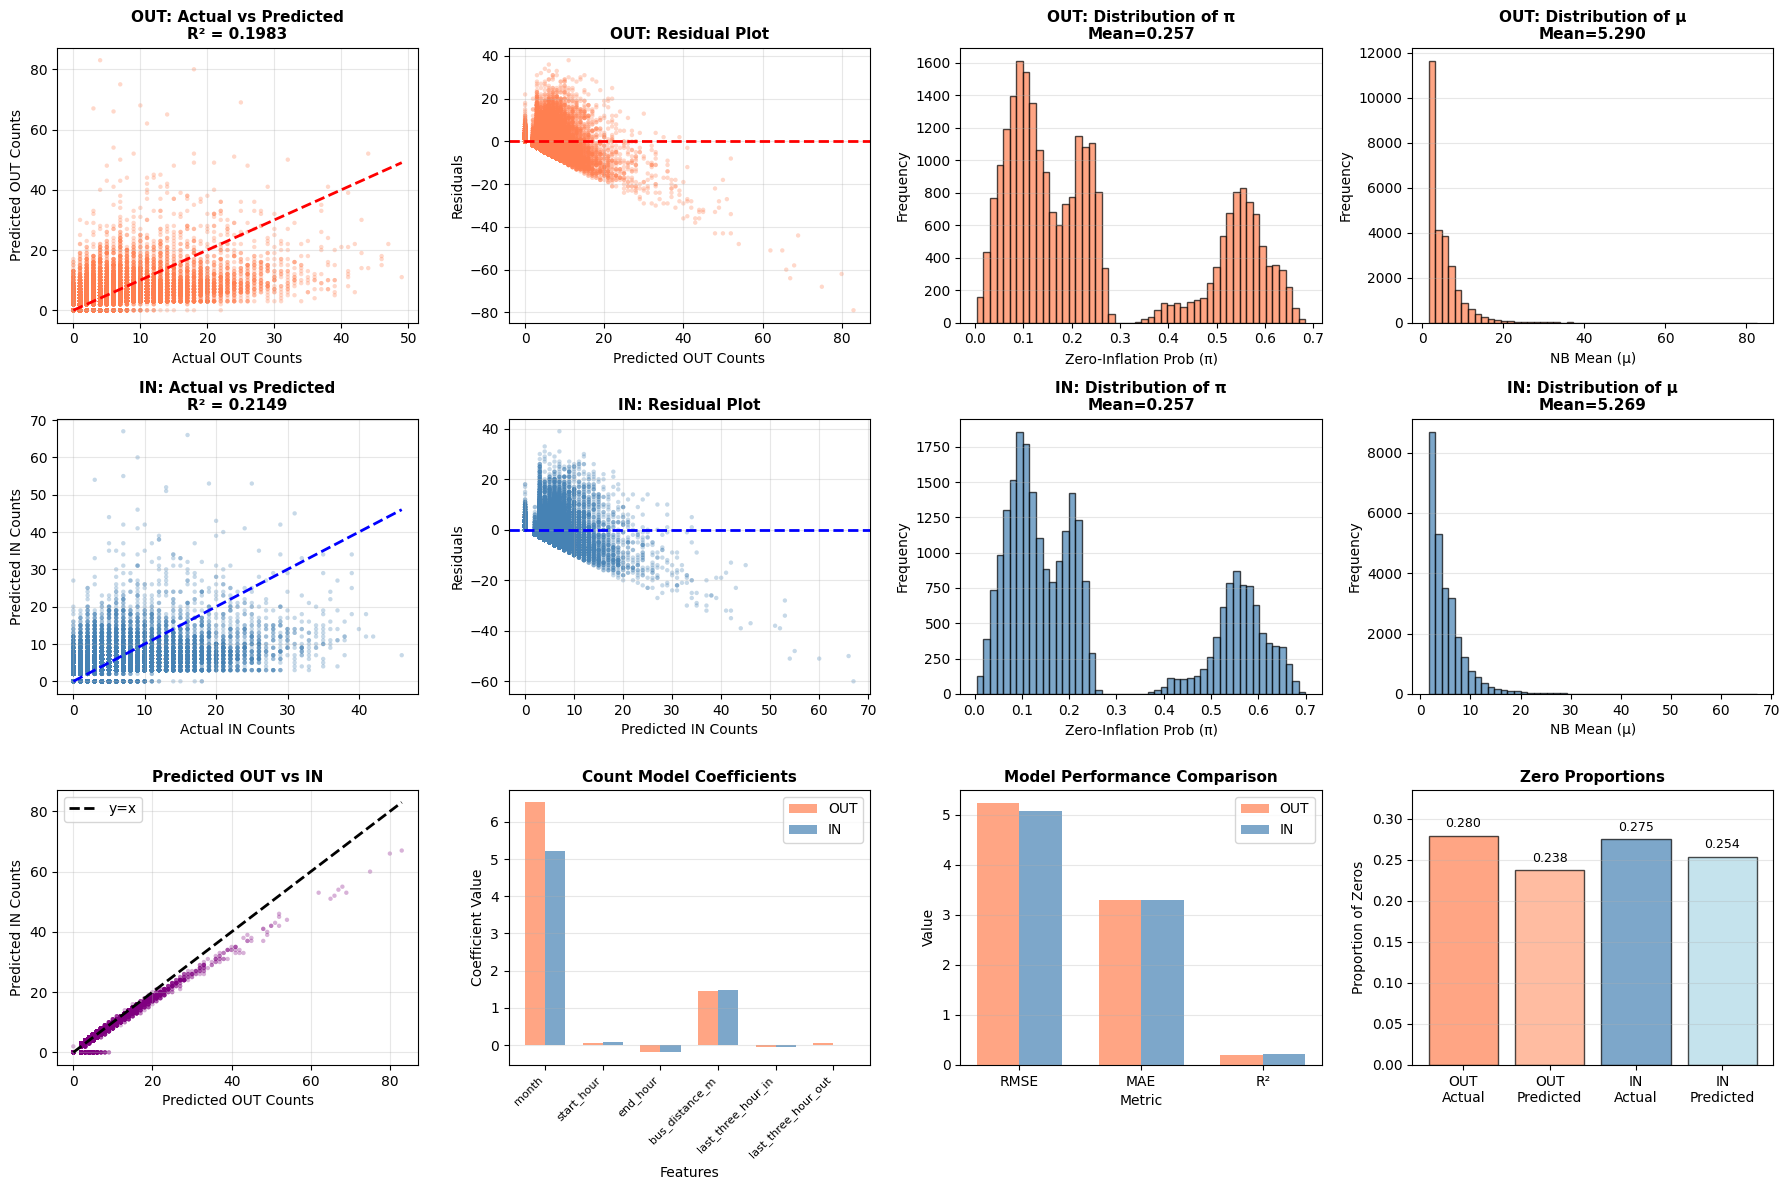


Model Comparison Summary

Metric                    OUT Model            IN Model            
----------------------------------------------------------------------
Overall Accuracy (%)      21.58                21.51               
RMSE                      5.2343               5.0750              
MAE                       3.2862               3.2928              
R²                        0.1983               0.2149              
Mean π                    0.2574               0.2573              
Mean μ                    5.2905               5.2686              
Dispersion α              0.7342               0.7366              
Actual Zero Prop          0.2796               0.2753              
Predicted Zero Prop       0.2376               0.2540              


In [135]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(18, 12))

# Row 1: OUT Model
# 1. OUT: Actual vs Predicted
ax1 = plt.subplot(3, 4, 1)
plt.scatter(y_out_test, y_out_pred, alpha=0.3, s=10, edgecolors='none', color='coral')
plt.plot([y_out_test.min(), y_out_test.max()], [y_out_test.min(), y_out_test.max()], 'r--', lw=2)
plt.xlabel('Actual OUT Counts', fontsize=10)
plt.ylabel('Predicted OUT Counts', fontsize=10)
plt.title(f'OUT: Actual vs Predicted\nR² = {r2_out:.4f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. OUT: Residuals
ax2 = plt.subplot(3, 4, 2)
residuals_out = y_out_test - y_out_pred
plt.scatter(y_out_pred, residuals_out, alpha=0.3, s=10, edgecolors='none', color='coral')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted OUT Counts', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.title('OUT: Residual Plot', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. OUT: Distribution of π
ax3 = plt.subplot(3, 4, 3)
plt.hist(pi_out_pred, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Zero-Inflation Prob (π)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'OUT: Distribution of π\nMean={pi_out_pred.mean():.3f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 4. OUT: Distribution of μ
ax4 = plt.subplot(3, 4, 4)
plt.hist(mu_out_pred, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('NB Mean (μ)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'OUT: Distribution of μ\nMean={mu_out_pred.mean():.3f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Row 2: IN Model
# 5. IN: Actual vs Predicted
ax5 = plt.subplot(3, 4, 5)
plt.scatter(y_in_test, y_in_pred, alpha=0.3, s=10, edgecolors='none', color='steelblue')
plt.plot([y_in_test.min(), y_in_test.max()], [y_in_test.min(), y_in_test.max()], 'b--', lw=2)
plt.xlabel('Actual IN Counts', fontsize=10)
plt.ylabel('Predicted IN Counts', fontsize=10)
plt.title(f'IN: Actual vs Predicted\nR² = {r2_in:.4f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# 6. IN: Residuals
ax6 = plt.subplot(3, 4, 6)
residuals_in = y_in_test - y_in_pred
plt.scatter(y_in_pred, residuals_in, alpha=0.3, s=10, edgecolors='none', color='steelblue')
plt.axhline(y=0, color='b', linestyle='--', lw=2)
plt.xlabel('Predicted IN Counts', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.title('IN: Residual Plot', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# 7. IN: Distribution of π
ax7 = plt.subplot(3, 4, 7)
plt.hist(pi_in_pred, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Zero-Inflation Prob (π)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'IN: Distribution of π\nMean={pi_in_pred.mean():.3f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 8. IN: Distribution of μ
ax8 = plt.subplot(3, 4, 8)
plt.hist(mu_in_pred, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('NB Mean (μ)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title(f'IN: Distribution of μ\nMean={mu_in_pred.mean():.3f}', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Row 3: Comparisons
# 9. OUT vs IN Predicted Counts
ax9 = plt.subplot(3, 4, 9)
plt.scatter(y_out_pred, y_in_pred, alpha=0.3, s=10, edgecolors='none', color='purple')
min_val = min(y_out_pred.min(), y_in_pred.min())
max_val = max(y_out_pred.max(), y_in_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='y=x')
plt.xlabel('Predicted OUT Counts', fontsize=10)
plt.ylabel('Predicted IN Counts', fontsize=10)
plt.title('Predicted OUT vs IN', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. Coefficient comparison for count models
ax10 = plt.subplot(3, 4, 10)
feature_names_no_const = [col for col in feature_names_with_const if col != 'const']
out_coefs = [count_params_out[i] for i, col in enumerate(feature_names_with_const) if col != 'const']
in_coefs = [count_params_in[i] for i, col in enumerate(feature_names_with_const) if col != 'const']
x_pos = np.arange(len(feature_names_no_const))
width = 0.35
plt.bar(x_pos - width/2, out_coefs, width, label='OUT', color='coral', alpha=0.7)
plt.bar(x_pos + width/2, in_coefs, width, label='IN', color='steelblue', alpha=0.7)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Coefficient Value', fontsize=10)
plt.title('Count Model Coefficients', fontsize=11, fontweight='bold')
plt.xticks(x_pos, feature_names_no_const, rotation=45, ha='right', fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# 11. Model Performance Comparison
ax11 = plt.subplot(3, 4, 11)
metrics = ['RMSE', 'MAE', 'R²']
out_metrics = [rmse_out, mae_out, r2_out]
in_metrics = [rmse_in, mae_in, r2_in]
x_pos = np.arange(len(metrics))
width = 0.35
plt.bar(x_pos - width/2, out_metrics, width, label='OUT', color='coral', alpha=0.7)
plt.bar(x_pos + width/2, in_metrics, width, label='IN', color='steelblue', alpha=0.7)
plt.xlabel('Metric', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.title('Model Performance Comparison', fontsize=11, fontweight='bold')
plt.xticks(x_pos, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 12. Zero proportions comparison
ax12 = plt.subplot(3, 4, 12)
zero_prop_out_actual = (y_out_test == 0).mean()
zero_prop_out_pred = (y_out_pred < 0.5).mean()
zero_prop_in_actual = (y_in_test == 0).mean()
zero_prop_in_pred = (y_in_pred < 0.5).mean()
categories = ['OUT\nActual', 'OUT\nPredicted', 'IN\nActual', 'IN\nPredicted']
values = [zero_prop_out_actual, zero_prop_out_pred, zero_prop_in_actual, zero_prop_in_pred]
colors = ['coral', 'lightsalmon', 'steelblue', 'lightblue']
plt.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Proportion of Zeros', fontsize=10)
plt.title('Zero Proportions', fontsize=11, fontweight='bold')
plt.ylim([0, max(values) * 1.2])
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

alpha_out_idx = len(zinb_out_results.params) - 1
alpha_out = zinb_out_results.params[alpha_out_idx]

# Get dispersion parameter for IN model
alpha_in_idx = len(zinb_in_results.params) - 1
alpha_in = zinb_in_results.params[alpha_in_idx]

# Summary comparison
print()
print("="*70)
print("Model Comparison Summary")
print("="*70)
print()

# Calculate prediction accuracy (exact matches after rounding)
accuracy_out = (y_out_pred == y_out_test).mean()
accuracy_in = (y_in_pred == y_in_test).mean()

print(f"{'Metric':<25} {'OUT Model':<20} {'IN Model':<20}")
print("-"*70)
print(f"{'Overall Accuracy (%)':<25} {accuracy_out*100:<20.2f} {accuracy_in*100:<20.2f}")
print(f"{'RMSE':<25} {rmse_out:<20.4f} {rmse_in:<20.4f}")
print(f"{'MAE':<25} {mae_out:<20.4f} {mae_in:<20.4f}")
print(f"{'R²':<25} {r2_out:<20.4f} {r2_in:<20.4f}")
print(f"{'Mean π':<25} {pi_out_pred.mean():<20.4f} {pi_in_pred.mean():<20.4f}")
print(f"{'Mean μ':<25} {mu_out_pred.mean():<20.4f} {mu_in_pred.mean():<20.4f}")
print(f"{'Dispersion α':<25} {alpha_out:<20.4f} {alpha_in:<20.4f}")
print(f"{'Actual Zero Prop':<25} {zero_prop_out_actual:<20.4f} {zero_prop_in_actual:<20.4f}")
print(f"{'Predicted Zero Prop':<25} {zero_prop_out_pred:<20.4f} {zero_prop_in_pred:<20.4f}")

